# DBSCAN

In [78]:
# imports

import pandas as pd
import numpy as np
from math import pi
from math import ceil, floor
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import random
import joblib
from tqdm import tqdm
import re
from IPython.display import clear_output
import mapply
mapply.init(n_workers=7, progressbar=True)
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import DBSCAN

In [4]:
# utils

cat_cols = ['date_month', 'date_day', 'date_year', 'congressional_district', 'state',
            'incident_characteristics1', 'city_or_county', 'party']

orig_num_cols = ['latitude', 'longitude', 'min_age_participants', 'avg_age_participants',
        'max_age_participants', 'n_participants_child', 'n_participants_teen',
        'n_participants_adult', 'n_males', 'n_females', 'n_killed', 'n_injured',
        'n_arrested', 'n_unharmed', 'n_participants',
        'povertyPercentage', 'candidatevotes', 'totalvotes']

K_MIN = 2
K_MAX = 20

OUTLIERS_REM = 'remove_outliers_iqr'
#OUTLIERS_REM = 'flag'
#SCALER = 'std'
SCALER = 'minmax'

MODEL_NAMES = ['Original Model', 'Augmented Model', 'Indicators Model', 'Original Reduced Model', 'Augmented Reduced Model', 'Indicators Reduced Model']

def remove_outliers_iqr(data, column, threshold=1.5):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]


def prepare(df, scaler='std', with_original=True, with_indicators=True):
    df.loc[:, cat_cols] = df.loc[:, cat_cols].astype('object')
    numerical_df = df.select_dtypes(include=['int64', 'float64'])

    if not with_indicators:
        if not with_original:
            return None
        numerical_df = numerical_df[orig_num_cols]
    elif not with_original:
        numerical_df = numerical_df[[col for col in numerical_df.columns if col not in orig_num_cols]]

    if scaler == 'minmax':
        scaler = MinMaxScaler()
    else:
        scaler = StandardScaler()
        
    numerical_scaled = scaler.fit_transform(numerical_df.values)
    numerical_scaled = pd.DataFrame(numerical_scaled, columns=numerical_df.columns)

    return numerical_df, numerical_scaled, scaler


def features_reduction_corr(df, correlation_threshold=0.7):
    # Compute the correlation matrix
    correlation_matrix = df.corr()

    # Identify highly correlated features
    highly_correlated_features = set()

    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
                colname = correlation_matrix.columns[i]
                highly_correlated_features.add(colname)

    # Remove highly correlated features
    df_filtered = df.drop(columns=highly_correlated_features)
    return df_filtered


def features_reduction_var(df, variance_threshold=2):
    # Compute the variance of each feature
    feature_variances = df.var()

    # Identify features below the variance threshold
    low_variance_features = feature_variances[feature_variances < variance_threshold].index

    # Prune (remove) features below the threshold
    df_pruned = df.drop(columns=low_variance_features)

    return df_pruned


def perform_PCA(df, centroids=None, n_components=2):
    pca = PCA(n_components=n_components)

    points_pca = pca.fit_transform(df)
    if centroids is not None:
        centroids_pca = pca.transform(centroids)
        return points_pca, centroids_pca
    return points_pca


def generate_random_df(stats_df, sample_size=1):
    columns = stats_df['Attribute'].tolist()
    random_row = {}
    for j in tqdm(range(len(columns))):
        col = columns[j]
        to_sample_from = stats_df[stats_df['Attribute'] == col]
        if to_sample_from['Possible Values'][j] is not None:
            random_row[col] = np.random.choice(to_sample_from['Possible Values'][j], size=sample_size)
        else:
            random_row[col] = np.random.uniform(to_sample_from['Min Value'][j], to_sample_from['Max Value'][j], size=sample_size)
    random_df = pd.DataFrame(random_row)
    return random_df



def augment(df):
    # from data cleaning ----------------------------------------------------------------------------------
    augmented_participants = df.copy()

    PREFIX = lambda c: f'p_{c[2:]}'

    participants_cols = ['n_males', 'n_females', 'n_participants_child', 'n_participants_teen', 'n_participants_adult', 'n_killed', 'n_injured', 'n_arrested', 'n_unharmed']

    # indicators

    # Age Change wrt the mean in the same (month, congressional_district)
    for col in participants_cols:
        augmented_participants[PREFIX(col)] = augmented_participants[col] / augmented_participants['n_participants']

    augmented_age = augmented_participants.copy()
    PREFIX = lambda cs: [f'month_cd_change_{c}' for c in cs]

    augmented_age = augmented_age.set_index(['date_year', 'date_month', 'state', 'congressional_district'])
    augmented_age = augmented_age.sort_index()

    cols = ['min_age_participants', 'avg_age_participants', 'max_age_participants']
    mean_val = augmented_age.groupby(augmented_age.index.names)[cols].mean()
    augmented_age[PREFIX(cols)] = augmented_age[cols] - mean_val

    augmented_age = augmented_age.reset_index()

    # Age Change wrt the mean in the same (month, state)
    PREFIX = lambda cs: [f'year_state_change_{c}' for c in cs]

    augmented_age = augmented_age.set_index(['date_year', 'state'])
    augmented_age = augmented_age.sort_index()

    cols = ['min_age_participants', 'avg_age_participants', 'max_age_participants']
    mean_val = augmented_age.groupby(augmented_age.index.names)[cols].mean()
    augmented_age[PREFIX(cols)] = augmented_age[cols] - mean_val

    augmented_age = augmented_age.reset_index()


    # Number of participants wrt the sum in that (month, congressional_district)
    augmented_p_ratio = augmented_age.copy()
    PREFIX = lambda cs: [f'month_cd_ratio_{c[2:]}' for c in cs]

    new_params = [p + '_ratio' for p in participants_cols]

    augmented_p_ratio = augmented_p_ratio.set_index(['date_year', 'date_month', 'state', 'congressional_district'])
    augmented_p_ratio = augmented_p_ratio.sort_index()
    sums = augmented_p_ratio.groupby(augmented_p_ratio.index.names)[participants_cols].sum()

    augmented_p_ratio[PREFIX(participants_cols)] = augmented_p_ratio[participants_cols].div(sums, axis=0)
    augmented_p_ratio = augmented_p_ratio.reset_index()

    # Number of participants wrt the sum in that (month, state)
    PREFIX = lambda cs: [f'year_state_ratio_{c[2:]}' for c in cs]

    new_params = [p + '_ratio' for p in participants_cols]

    augmented_p_ratio = augmented_p_ratio.set_index(['date_year', 'state'])
    augmented_p_ratio = augmented_p_ratio.sort_index()
    sums = augmented_p_ratio.groupby(augmented_p_ratio.index.names)[participants_cols].sum()

    augmented_p_ratio[PREFIX(participants_cols)] = augmented_p_ratio[participants_cols].div(sums, axis=0)
    augmented_p_ratio = augmented_p_ratio.reset_index()

    # Replace NaNs (0/0) with 0
    augmented_p_ratio = augmented_p_ratio.fillna(0)

    augmented_incidents = augmented_p_ratio.copy()
    PREFIX = lambda _: 'month_cd_incidents'

    augmented_incidents = augmented_incidents.set_index(['date_year', 'date_month', 'state', 'congressional_district'])
    augmented_incidents = augmented_incidents.sort_index()
    augmented_incidents['month_cd_incidents'] = augmented_incidents.groupby(augmented_incidents.index.names).size()
    augmented_incidents['month_cd_votes_incidents'] = augmented_incidents['month_cd_incidents'] / augmented_incidents['totalvotes']

    augmented_incidents = augmented_incidents.reset_index()

    augmented_incidents = augmented_incidents.set_index(['date_year', 'state'])
    augmented_incidents = augmented_incidents.sort_index()
    augmented_incidents['year_state_incidents'] = augmented_incidents.groupby(augmented_incidents.index.names).size()

    augmented_incidents = augmented_incidents.reset_index()

    augmented_population = augmented_incidents.copy()

    votes = df.copy()
    votes = votes[['date_year', 'state', 'congressional_district', 'totalvotes']]
    votes = votes.set_index(['date_year', 'state', 'congressional_district'])
    votes = votes.sort_index()

    state_votes = votes.groupby(['date_year', 'state']).sum()

    augmented_population = augmented_population.set_index(['date_year', 'state', 'congressional_district'])
    augmented_population = augmented_population.sort_index()

    cd_population = augmented_population['totalvotes'] * augmented_population['state_population'] // state_votes['totalvotes']
    cd_population.dropna(inplace=True)

    augmented_population['cd_population'] = cd_population

    augmented_population = augmented_population.reset_index()

    augmented_party = augmented_population.copy()

    REP_df = augmented_party[augmented_party['party'] == 'REPUBLICAN'].copy()
    DEM_df = augmented_party[augmented_party['party'] == 'DEMOCRAT'].copy()
    REP_df['percentage_republican'] = REP_df['candidatevotes'] / REP_df['totalvotes']
    REP_df['percentage_democrat'] = 1 - (REP_df['candidatevotes'] / REP_df['totalvotes'])
    DEM_df['percentage_democrat'] = DEM_df['candidatevotes'] / DEM_df['totalvotes']
    DEM_df['percentage_republican'] = 1 - (DEM_df['candidatevotes'] / DEM_df['totalvotes'])
    augmented_party = pd.concat([REP_df, DEM_df], ignore_index=True).reset_index(drop=True).sample(frac=1)

    regex = re.compile('[^a-zA-Z0-9]')
    def rename(s):
        return regex.sub('_', s)

    k = 4

    augmented_charateristics = augmented_party.copy()

    vc = augmented_charateristics['incident_characteristics1'].value_counts()
    most_common = vc.head(k).index.tolist()

    augmented_charateristics = augmented_charateristics.set_index(['date_year', 'date_month', 'state', 'congressional_district', 'incident_characteristics1'])
    augmented_charateristics = augmented_charateristics.sort_index()
    something = augmented_charateristics.groupby(['date_year', 'date_month', 'state', 'congressional_district', 'incident_characteristics1']).size()
    morething = augmented_charateristics.groupby(['date_year', 'date_month', 'state', 'congressional_district']).size()

    # create a column for each of the k most common incident_characteristics1 plus a column for the others
    for c in most_common:
        nc = rename(c)
        nc = 'cd_month_' + nc
        perc_state_month = something.xs(c, level='incident_characteristics1') / morething
        perc_state_month.fillna(0, inplace=True)
        augmented_charateristics[nc] = perc_state_month
    nc = 'cd_month_OTHER'
    perc_state_month = 1 - augmented_charateristics[['cd_month_' + rename(c) for c in most_common]].sum(axis=1)
    augmented_charateristics[nc] = perc_state_month

    augmented_charateristics = augmented_charateristics.reset_index()

    augmented_charateristics = augmented_charateristics.set_index(['date_year', 'state', 'incident_characteristics1'])
    augmented_charateristics = augmented_charateristics.sort_index()
    something = augmented_charateristics.groupby(['date_year', 'state', 'incident_characteristics1']).size()
    morething = augmented_charateristics.groupby(['date_year', 'state']).size()

    # create a column for each of the k most common incident_characteristics1 plus a column for the others
    for c in most_common:
        nc = rename(c)
        nc = 'state_year_' + nc
        perc_state_month = something.xs(c, level='incident_characteristics1') / morething
        perc_state_month.fillna(0, inplace=True)
        augmented_charateristics[nc] = perc_state_month
    nc = 'state_year_OTHER'
    perc_state_month = 1 - augmented_charateristics[['state_year_' + rename(c) for c in most_common]].sum(axis=1)
    augmented_charateristics[nc] = perc_state_month

    df = augmented_charateristics.reset_index()
    
    return df

---
## Preparing datasets

In [7]:
df_init = pd.read_csv('./dataset/data/final_clean2.csv')
df_init = df_init[df_init['state'] == 'CALIFORNIA']

if OUTLIERS_REM == 'flag':
    df_init = df_init[df_init['OUTLIER'] == 0]
else:
    for col in orig_num_cols:
        df_init = remove_outliers_iqr(df_init, col)

cols = cat_cols + orig_num_cols + ['state_population', 'timestamp']
df_init = df_init[cols]
df_init = augment(df_init)
#-------------------------------------------------------------------

summary_stats = pd.DataFrame({
    'Unique Values': df_init.nunique(),
    'Max Value': df_init.max(),
    'Min Value': df_init.min()
})
summary_stats['Possible Values'] = df_init.apply(lambda col: col.unique() if col.nunique() <= 8000 else None)
summary_stats = summary_stats.reset_index().rename(columns={'index': 'Attribute'})

random_df_init = generate_random_df(stats_df=summary_stats, sample_size=len(df_init.values))
random_df_init = augment(random_df_init)

100%|██████████| 77/77 [00:00<00:00, 1223.62it/s]


### Actual data

Dataset dimentions: (6026, 77)
Dataset dimentions without ouliers, with only numerical cols, without indicators: (6026, 18)
Dataset dimentions without ouliers, with only numerical cols, with indicators: (6026, 69)
Dataset dimentions without ouliers, with only numerical cols, only indicators: (6026, 51)


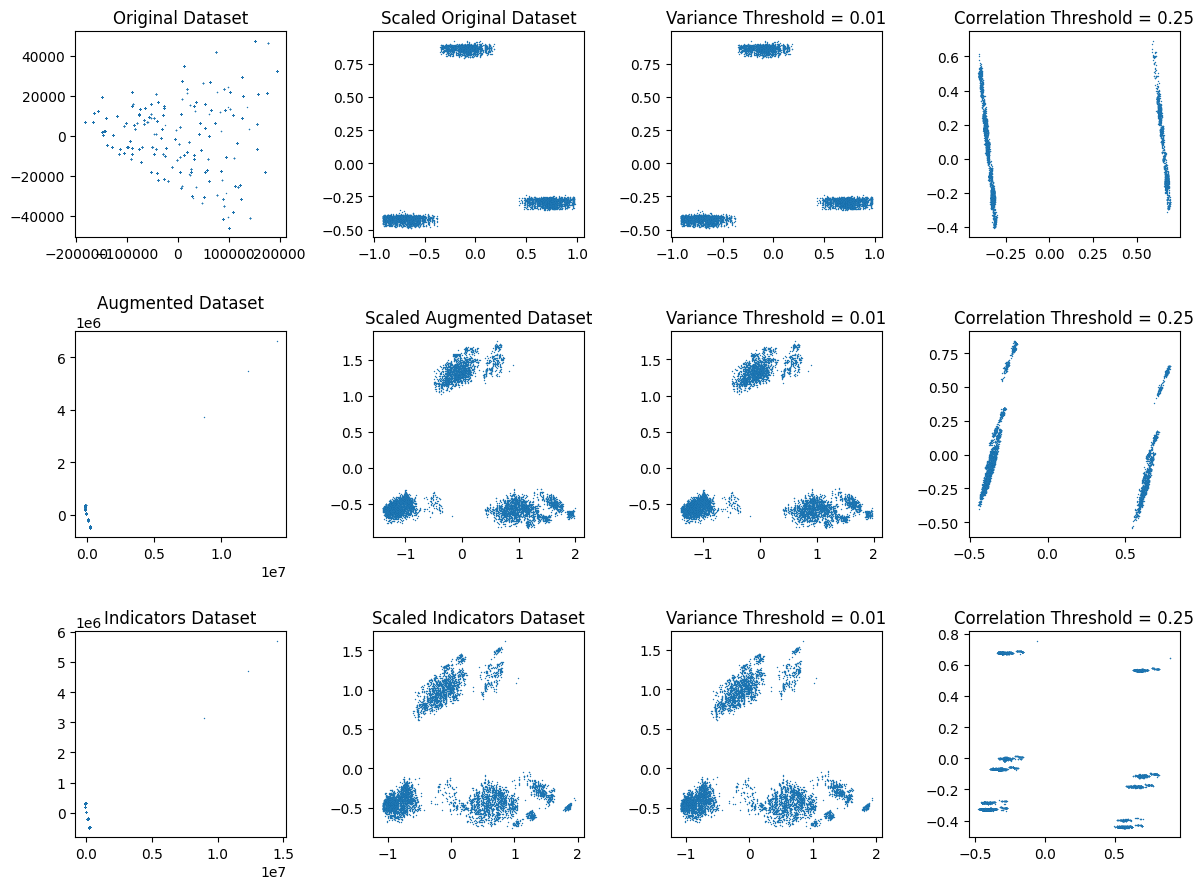

Original Dataset

Initial n_cols = 18

Survived columns (variance_threshold = 0.01):----------------------------------------------
n_cols = 11
Index(['latitude', 'longitude', 'min_age_participants', 'avg_age_participants',
       'max_age_participants', 'n_killed', 'n_injured', 'n_arrested',
       'povertyPercentage', 'candidatevotes', 'totalvotes'],
      dtype='object')

Survived columns (correlation_threshold = 0.25):----------------------------------------------
n_cols = 3
Index(['latitude', 'min_age_participants', 'n_killed'], dtype='object')

Augmented Dataset

Initial n_cols = 69

Survived columns (variance_threshold = 0.01):----------------------------------------------
n_cols = 43
Index(['latitude', 'longitude', 'min_age_participants', 'avg_age_participants',
       'max_age_participants', 'n_killed', 'n_injured', 'n_arrested',
       'povertyPercentage', 'candidatevotes', 'totalvotes', 'state_population',
       'timestamp', 'p_killed', 'p_injured', 'p_arrested',
       'mon

In [8]:
df_orig, df_orig_s, scaler_orig = prepare(df=df_init, scaler=SCALER, with_indicators=False, with_original=True)
df, df_s, scaler = prepare(df=df_init, scaler=SCALER, with_indicators=True, with_original=True)
df_ind, df_ind_s, scaler_ind = prepare(df=df_init, scaler=SCALER, with_indicators=True, with_original=False)

print(f'Dataset dimentions: {df_init.shape}')
print(f'Dataset dimentions without ouliers, with only numerical cols, without indicators: {df_orig.shape}')
print(f'Dataset dimentions without ouliers, with only numerical cols, with indicators: {df.shape}')
print(f'Dataset dimentions without ouliers, with only numerical cols, only indicators: {df_ind.shape}')

dataframes = [df_orig, df, df_ind]
scaled_dataframes = [df_orig_s, df_s, df_ind_s]
scalers = [scaler_orig, scaler, scaler_ind]
titles = ['Original Dataset', 'Augmented Dataset', 'Indicators Dataset']
N = len(dataframes)

if SCALER == 'minmax':
    var_thr = 0.01
    corr_thr = 0.25
else:
    var_thr = 1
    corr_thr = 0.25

reduced1s = []
reduced2s = []

for ds in scaled_dataframes:
    rs1 = features_reduction_var(ds, variance_threshold=var_thr)
    rs2 = features_reduction_corr(rs1, correlation_threshold=corr_thr)
    reduced1s.append(rs1)
    reduced2s.append(rs2)

scaled_dataframes = scaled_dataframes + reduced2s
dataframes = dataframes*2
scalers = scalers*2

plt.figure(figsize=(12, 9))

for d, ds, rs1, rs2, t, i in zip(dataframes, scaled_dataframes, reduced1s, reduced2s, titles, np.arange(1, N*4, 4)):

    pca = perform_PCA(df=d, n_components=2)
    pca_s = perform_PCA(df=ds, n_components=2)
    pca_rs1 = perform_PCA(df=rs1, n_components=2)
    pca_rs2 = perform_PCA(df=rs2, n_components=2)

    plt.subplot(3, 4, i)
    plt.scatter(pca[:, 0], pca[:, 1], s=1, edgecolors='black', linewidths=0.001)
    plt.title(t)

    plt.subplot(3, 4, i+1)
    plt.scatter(pca_s[:, 0], pca_s[:, 1], s=1, edgecolors='black', linewidths=0.001)
    plt.title(f'Scaled {t}')

    plt.subplot(3, 4, i+2)
    plt.scatter(pca_rs1[:, 0], pca_rs1[:, 1], s=1, edgecolors='black', linewidths=0.001)
    plt.title(f'Variance Threshold = {var_thr}')

    plt.subplot(3, 4, i+3)
    plt.scatter(pca_rs2[:, 0], pca_rs2[:, 1], s=1, edgecolors='black', linewidths=0.001)
    plt.title(f'Correlation Threshold = {corr_thr}')

plt.tight_layout()
plt.show()

for ds, rs1, rs2, t in zip(scaled_dataframes, reduced1s, reduced2s, titles):
    print(f'{t}\n\nInitial n_cols = {ds.shape[1]}')
    print(f'\nSurvived columns (variance_threshold = {var_thr}):----------------------------------------------')
    print(f'n_cols = {len(rs1.columns)}')
    print(rs1.columns)

    print(f'\nSurvived columns (correlation_threshold = {corr_thr}):----------------------------------------------')
    print(f'n_cols = {len(rs2.columns)}')
    print(f'{rs2.columns}\n')

### Random data

Dataset dimentions: (6026, 81)
Dataset dimentions without ouliers, with only numerical cols, without indicators: (6026, 18)
Dataset dimentions without ouliers, with only numerical cols, with indicators: (6026, 73)
Dataset dimentions without ouliers, with only numerical cols, only indicators: (6026, 55)


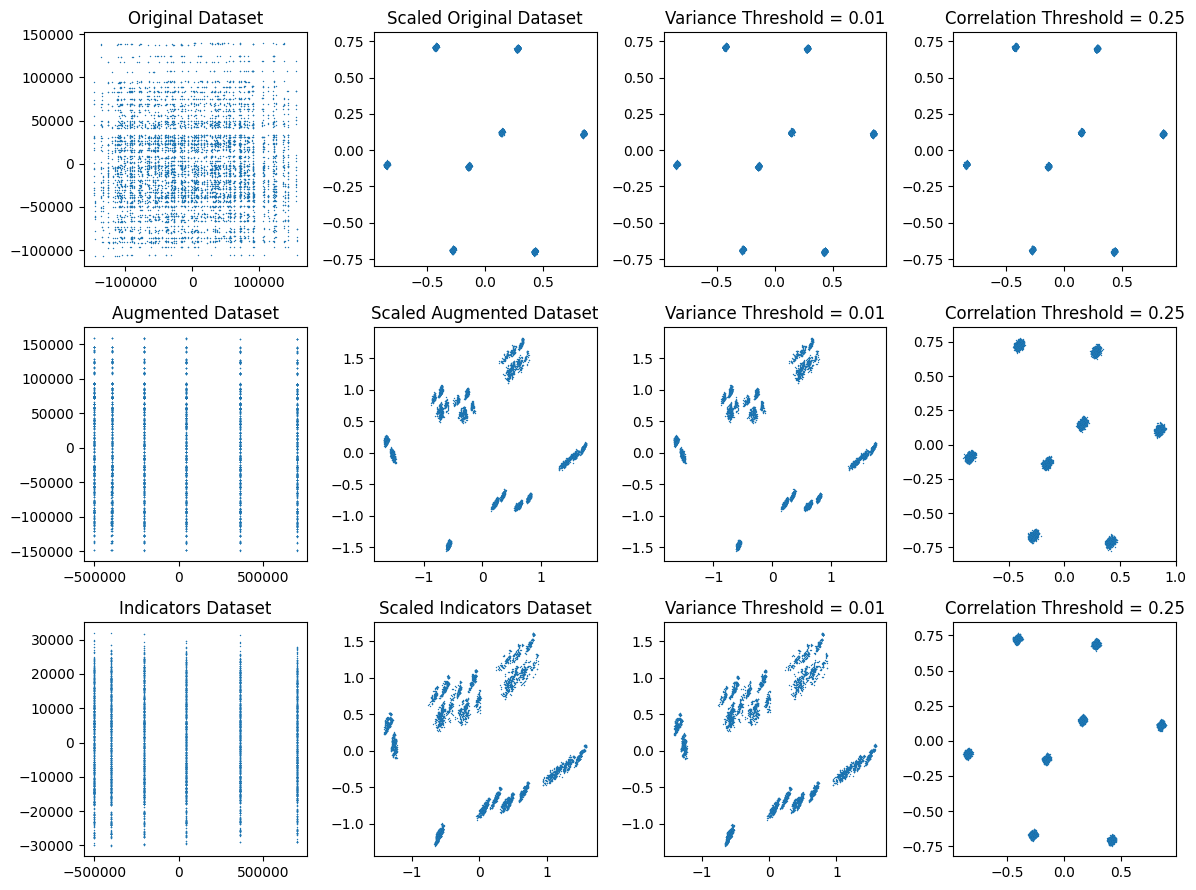

Original Dataset

Initial n_cols = 18

Survived columns (variance_threshold = 0.01):----------------------------------------------
n_cols = 11
Index(['latitude', 'longitude', 'min_age_participants', 'avg_age_participants',
       'max_age_participants', 'n_killed', 'n_injured', 'n_arrested',
       'povertyPercentage', 'candidatevotes', 'totalvotes'],
      dtype='object')

Survived columns (correlation_threshold = 0.25):----------------------------------------------
n_cols = 11
Index(['latitude', 'longitude', 'min_age_participants', 'avg_age_participants',
       'max_age_participants', 'n_killed', 'n_injured', 'n_arrested',
       'povertyPercentage', 'candidatevotes', 'totalvotes'],
      dtype='object')

Augmented Dataset

Initial n_cols = 73

Survived columns (variance_threshold = 0.01):----------------------------------------------
n_cols = 49
Index(['latitude', 'longitude', 'min_age_participants', 'avg_age_participants',
       'max_age_participants', 'n_killed', 'n_injured', 'n

In [9]:
random_df_orig, random_df_orig_s, random_scaler_orig = prepare(df=random_df_init, scaler=SCALER, with_indicators=False, with_original=True)
random_df, random_df_s, random_scaler = prepare(df=random_df_init, scaler=SCALER, with_indicators=True, with_original=True)
random_df_ind, random_df_ind_s, random_scaler_ind = prepare(df=random_df_init, scaler=SCALER, with_indicators=True, with_original=False)

print(f'Dataset dimentions: {random_df_init.shape}')
print(f'Dataset dimentions without ouliers, with only numerical cols, without indicators: {random_df_orig.shape}')
print(f'Dataset dimentions without ouliers, with only numerical cols, with indicators: {random_df.shape}')
print(f'Dataset dimentions without ouliers, with only numerical cols, only indicators: {random_df_ind.shape}')

random_dataframes = [random_df_orig, random_df, random_df_ind]
random_scaled_dataframes = [random_df_orig_s, random_df_s, random_df_ind_s]
random_scalers = [random_scaler_orig, random_scaler, random_scaler_ind]
titles = ['Original Dataset', 'Augmented Dataset', 'Indicators Dataset']
N = len(random_dataframes)

if SCALER == 'minmax':
    var_thr = 0.01
    corr_thr = 0.25
else:
    var_thr = 1
    corr_thr = 0.25

reduced1s = []
reduced2s = []

for ds in random_scaled_dataframes:
    rs1 = features_reduction_var(ds, variance_threshold=var_thr)
    rs2 = features_reduction_corr(rs1, correlation_threshold=corr_thr)
    reduced1s.append(rs1)
    reduced2s.append(rs2)

random_scaled_dataframes = random_scaled_dataframes + reduced2s
random_dataframes = random_dataframes*2
random_scalers = random_scalers*2

plt.figure(figsize=(12, 9))

for d, ds, rs1, rs2, t, i in zip(random_dataframes, random_scaled_dataframes, reduced1s, reduced2s, titles, np.arange(1, N*4, 4)):

    pca = perform_PCA(df=d, n_components=2)
    pca_s = perform_PCA(df=ds, n_components=2)
    pca_rs1 = perform_PCA(df=rs1, n_components=2)
    pca_rs2 = perform_PCA(df=rs2, n_components=2)

    plt.subplot(3, 4, i)
    plt.scatter(pca[:, 0], pca[:, 1], s=1, edgecolors='black', linewidths=0.001)
    plt.title(t)

    plt.subplot(3, 4, i+1)
    plt.scatter(pca_s[:, 0], pca_s[:, 1], s=1, edgecolors='black', linewidths=0.001)
    plt.title(f'Scaled {t}')

    plt.subplot(3, 4, i+2)
    plt.scatter(pca_rs1[:, 0], pca_rs1[:, 1], s=1, edgecolors='black', linewidths=0.001)
    plt.title(f'Variance Threshold = {var_thr}')

    plt.subplot(3, 4, i+3)
    plt.scatter(pca_rs2[:, 0], pca_rs2[:, 1], s=1, edgecolors='black', linewidths=0.001)
    plt.title(f'Correlation Threshold = {corr_thr}')

plt.tight_layout()
plt.show()

for ds, rs1, rs2, t in zip(random_scaled_dataframes, reduced1s, reduced2s, titles):
    print(f'{t}\n\nInitial n_cols = {ds.shape[1]}')
    print(f'\nSurvived columns (variance_threshold = {var_thr}):----------------------------------------------')
    print(f'n_cols = {len(rs1.columns)}')
    print(rs1.columns)

    print(f'\nSurvived columns (correlation_threshold = {corr_thr}):----------------------------------------------')
    print(f'n_cols = {len(rs2.columns)}')
    print(f'{rs2.columns}\n')

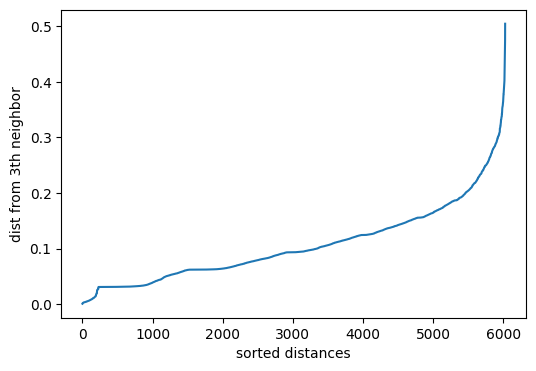

In [11]:
# visualize knee

k = 3

dist = pdist(scaled_dataframes[0], 'euclidean')
dist = squareform(dist)

kth_distances = list()
for d in dist:
    index_kth_distance = np.argsort(d)[k]
    kth_distances.append(d[index_kth_distance])
kth_distances_df = pd.DataFrame(kth_distances)
kth_distances_df = kth_distances_df.rolling(window=1).mean()
kth_distancess = kth_distances_df.values.tolist()
sorted_kth_distances = sorted(kth_distancess)

plt.figure(figsize=(6, 4))
plt.plot(range(0, len(kth_distancess)), sorted_kth_distances)
plt.ylabel(f'dist from {k}th neighbor', fontsize=10)
plt.xlabel('sorted distances', fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.show()

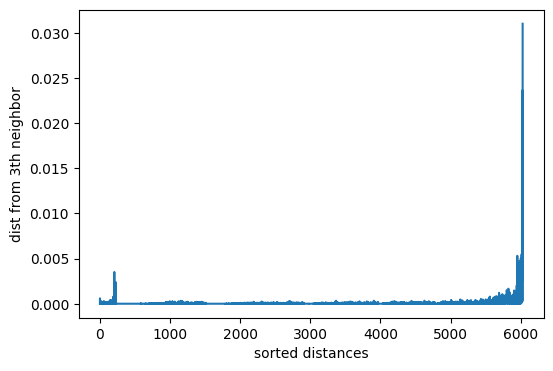

1.0531409023184501e-06


In [13]:
# visualize knee grad 

sorted_kth_distances_ = [x[0] for x in sorted_kth_distances[2:]]
secnd_grad = np.diff(sorted_kth_distances_, n=1)

plt.figure(figsize=(6, 4))
plt.plot(range(3, len(kth_distancess)), secnd_grad)
plt.ylabel(f'dist from {k}th neighbor', fontsize=10)
plt.xlabel('sorted distances', fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.show()

print(secnd_grad[5500])

---
## Perform DBSCAN clustering

In [187]:
# searching in the space of hyperparameters min_samples and eps
# clustering
# clustering evaluation (silhouette) <-> state (min_samples, eps) evaluation

all_best_models = []
all_best_sils = []
model_names = MODEL_NAMES + ['Random ' + name for name in MODEL_NAMES]
all_dataframes = scaled_dataframes + random_scaled_dataframes
for scaled_dataframe, model_name in zip(all_dataframes, model_names):

    min_min_samples = 1
    max_min_samples = len(scaled_dataframe)
    min_samples_step = 1000

    min_eps = 0.1
    max_eps = np.max(pdist(scaled_dataframe, 'euclidean'))
    eps_step = 1

    min_samples_s = np.arange(min_min_samples, max_min_samples, min_samples_step)
    eps_s = np.arange(min_eps, max_eps, eps_step)

    while len(range(min_min_samples, max_min_samples)) > 1:
        print(f'Interval len: {len(range(min_min_samples, max_min_samples))}, min_samples_step: {min_samples_step}, Values to try: {len(min_samples_s)}')
        silhouettes = []
        models = []

        i = 1
        for min_samples in tqdm(min_samples_s, desc=f'{model_name} min_samples', position=0, leave=True):
            for eps in tqdm(eps_s, desc='eps', position=1, leave=False):
                dbscan = DBSCAN(eps=eps, min_samples=min_samples)
                dbscan.fit(scaled_dataframe)
                models.append(dbscan)

        for model in tqdm(models, desc=model_name+' silhouette', position=0, leave=True):
            n_labels = len(np.unique(model.labels_))
            if n_labels > 1 and n_labels < len(scaled_dataframe):
                sil = silhouette_score(scaled_dataframe, model.labels_)
            else:
                sil = -2
            silhouettes.append(sil)

        best_model = models[np.argmax(silhouettes)]

        max_min_samples = best_model.min_samples + floor(min_samples_step / 4)
        min_min_samples = best_model.min_samples - floor(min_samples_step / 4) + 1
        if min_min_samples < 1:
            min_min_samples = 1 + i
            i += 1
        min_samples_step = np.max([floor(len(range(min_min_samples, max_min_samples)) / 10), 1])
        min_samples_s = np.arange(min_min_samples, max_min_samples, min_samples_step)

    max_eps = best_model.eps + eps_step
    min_eps = np.max([best_model.eps - eps_step, 0.1])
    eps_s = np.arange(min_eps, max_eps, 0.5)
    models = []

    for eps in tqdm(eps_s, desc=model_name+' eps', position=0, leave=True):
        dbscan = DBSCAN(eps=eps, min_samples=best_model.min_samples)
        dbscan.fit(scaled_dataframe)
        models.append(dbscan)

    silhouettes = []
    for model in tqdm(models, desc=model_name+' silhouette', position=0, leave=True):
        n_labels = len(np.unique(model.labels_))
        if n_labels > 1 and n_labels < len(scaled_dataframe):
            sil = silhouette_score(scaled_dataframe, model.labels_)
        else:
            sil = -2
        silhouettes.append(sil)

    all_best_models.append(models[np.argmax(silhouettes)])
    all_best_sils.append(np.max(silhouettes))

Interval len: 6025, min_samples_step: 1000, Values to try: 7


Original Model silhouette: 100%|██████████| 21/21 [00:02<00:00,  8.52it/s]


Interval len: 249, min_samples_step: 24, Values to try: 11


Original Model silhouette: 100%|██████████| 33/33 [00:07<00:00,  4.33it/s]


Interval len: 6, min_samples_step: 1, Values to try: 6


Original Model silhouette: 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]


Interval len: 6025, min_samples_step: 1000, Values to try: 7


Augmented Model silhouette: 100%|██████████| 35/35 [00:03<00:00, 10.44it/s]


Interval len: 499, min_samples_step: 49, Values to try: 11


Augmented Model silhouette: 100%|██████████| 55/55 [00:04<00:00, 13.35it/s]


Interval len: 23, min_samples_step: 2, Values to try: 12


Augmented Model silhouette: 100%|██████████| 4/4 [00:01<00:00,  3.34it/s]


Interval len: 6025, min_samples_step: 1000, Values to try: 7


Indicators Model silhouette: 100%|██████████| 35/35 [00:05<00:00,  6.88it/s]


Interval len: 499, min_samples_step: 49, Values to try: 11


Indicators Model silhouette: 100%|██████████| 55/55 [00:08<00:00,  6.51it/s]


Interval len: 23, min_samples_step: 2, Values to try: 12


Indicators Model silhouette: 100%|██████████| 4/4 [00:01<00:00,  2.70it/s]


Interval len: 6025, min_samples_step: 1000, Values to try: 7


Original Reduced Model silhouette: 100%|██████████| 14/14 [00:00<00:00, 30.06it/s]


Interval len: 249, min_samples_step: 24, Values to try: 11


Original Reduced Model silhouette: 100%|██████████| 22/22 [00:04<00:00,  4.45it/s]


Interval len: 11, min_samples_step: 1, Values to try: 11


Original Reduced Model silhouette: 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]


Interval len: 6025, min_samples_step: 1000, Values to try: 7


Augmented Reduced Model silhouette: 100%|██████████| 14/14 [00:01<00:00, 11.57it/s]


Interval len: 499, min_samples_step: 49, Values to try: 11


Augmented Reduced Model silhouette: 100%|██████████| 22/22 [00:05<00:00,  4.24it/s]


Interval len: 23, min_samples_step: 2, Values to try: 12


Augmented Reduced Model silhouette: 100%|██████████| 4/4 [00:00<00:00,  8.47it/s]


Interval len: 6025, min_samples_step: 1000, Values to try: 7


Indicators Reduced Model silhouette: 100%|██████████| 14/14 [00:01<00:00, 10.08it/s]


Interval len: 499, min_samples_step: 49, Values to try: 11


Indicators Reduced Model silhouette: 100%|██████████| 22/22 [00:06<00:00,  3.53it/s]


Interval len: 23, min_samples_step: 2, Values to try: 12


Indicators Reduced Model silhouette: 100%|██████████| 4/4 [00:00<00:00,  8.53it/s]


Interval len: 6025, min_samples_step: 1000, Values to try: 7


Random Original Model silhouette: 100%|██████████| 21/21 [00:00<00:00, 28.10it/s]


Interval len: 249, min_samples_step: 24, Values to try: 11


Random Original Model silhouette: 100%|██████████| 33/33 [00:00<00:00, 69.73it/s]


Interval len: 6, min_samples_step: 1, Values to try: 6


Random Original Model silhouette: 100%|██████████| 2/2 [00:00<00:00,  2.10it/s]


Interval len: 6025, min_samples_step: 1000, Values to try: 7


Random Augmented Model silhouette: 100%|██████████| 42/42 [00:00<00:00, 45.75it/s]


Interval len: 249, min_samples_step: 24, Values to try: 11


Random Augmented Model silhouette: 100%|██████████| 66/66 [00:03<00:00, 18.48it/s]


Interval len: 11, min_samples_step: 1, Values to try: 11


Random Augmented Model silhouette: 100%|██████████| 4/4 [00:00<00:00,  7.73it/s]


Interval len: 6025, min_samples_step: 1000, Values to try: 7


Random Indicators Model silhouette: 100%|██████████| 35/35 [00:01<00:00, 32.61it/s]


Interval len: 499, min_samples_step: 49, Values to try: 11


Random Indicators Model silhouette: 100%|██████████| 55/55 [00:05<00:00,  9.37it/s]


Interval len: 23, min_samples_step: 2, Values to try: 12


Random Indicators Model silhouette: 100%|██████████| 4/4 [00:00<00:00,  8.04it/s]


Interval len: 6025, min_samples_step: 1000, Values to try: 7


Random Original Reduced Model silhouette: 100%|██████████| 21/21 [00:00<00:00, 28.39it/s]


Interval len: 249, min_samples_step: 24, Values to try: 11


Random Original Reduced Model silhouette: 100%|██████████| 33/33 [00:00<00:00, 51.59it/s]


Interval len: 6, min_samples_step: 1, Values to try: 6


Random Original Reduced Model silhouette: 100%|██████████| 2/2 [00:00<00:00,  2.28it/s]


Interval len: 6025, min_samples_step: 1000, Values to try: 7


Random Augmented Reduced Model silhouette: 100%|██████████| 28/28 [00:00<00:00, 65.67it/s]


Interval len: 249, min_samples_step: 24, Values to try: 11


Random Augmented Reduced Model silhouette: 100%|██████████| 44/44 [00:01<00:00, 24.10it/s]


Interval len: 11, min_samples_step: 1, Values to try: 11


Random Augmented Reduced Model silhouette: 100%|██████████| 4/4 [00:00<00:00,  9.46it/s]


Interval len: 6025, min_samples_step: 1000, Values to try: 7


Random Indicators Reduced Model silhouette: 100%|██████████| 28/28 [00:00<00:00, 58.53it/s]


Interval len: 249, min_samples_step: 24, Values to try: 11


Random Indicators Reduced Model silhouette: 100%|██████████| 44/44 [00:05<00:00,  8.55it/s]


Interval len: 11, min_samples_step: 1, Values to try: 11


Random Indicators Reduced Model silhouette: 100%|██████████| 4/4 [00:00<00:00,  8.39it/s]


---
## Analysis

In [192]:
# organize results
# save results

file_names = ['Orig', 'Augm', 'Ind']
file_names = file_names + [name+'Red' for name in file_names]
file_names = file_names + ['Random'+name for name in file_names]
sils = {
    'Model': [],
    'Silhouette': []
}
for i in range(len(all_best_models)):
    joblib.dump(all_best_models[i], f'models/DBSCAN_{file_names[i]}MMS.pkl')
    sils['Model'].append(model_names[i])
    sils['Silhouette'].append(all_best_sils[i])
pd.DataFrame(sils).to_csv(f'models/DBSCAN_SilsMMS.csv', index=True)

In [196]:
# organize results
# visualize result

sils['N_clusters'] = []
sils['Clusters'] = []
sils['Cluster_sizes'] = []

for model, data in zip(all_best_models, all_dataframes):
    clusters = np.unique(model.labels_)
    sils['Clusters'].append(clusters)
    sils['N_clusters'].append(len(clusters))
    labels = model.labels_
    sils['Cluster_sizes'].append([np.sum(labels == label) for label in clusters])
sils_df = pd.DataFrame(sils)
sils_df

Model  Silhouette  N_clusters  \
0                    Original Model    0.512991           3   
1                   Augmented Model    0.363923           3   
2                  Indicators Model    0.398063           2   
3            Original Reduced Model    0.670266           2   
4           Augmented Reduced Model    0.449460           2   
5          Indicators Reduced Model    0.258194           2   
6             Random Original Model    0.274391           9   
7            Random Augmented Model    0.121499           2   
8           Random Indicators Model    0.122143           2   
9     Random Original Reduced Model    0.274391           9   
10   Random Augmented Reduced Model    0.032228           8   
11  Random Indicators Reduced Model    0.138563           2   

                                   Cluster_sizes                      Clusters  
0                             [2088, 1758, 2180]                     [0, 1, 2]  
1                             [1755, 2198, 2073]                    [-1, 0, 1]  
2                                      [3, 6023]                       [-1, 0]  
3                                   [2088, 3938]                        [0, 1]  
4                                      [3, 6023]                       [-1, 0]  
5                                    [830, 5196]                       [-1, 0]  
6   [11, 787, 763, 762, 730, 774, 748, 741, 710]  [-1, 0, 1, 2, 3, 4, 5, 6, 7]  
7                                      [1, 6025]                       [-1, 0]  
8                                    [133, 5893]                       [-1, 0]  
9   [11, 787, 763, 762, 730, 774, 748, 741, 710]  [-1, 0, 1, 2, 3, 4, 5, 6, 7]  
10     [1949, 985, 575, 496, 484, 504, 523, 510]     [-1, 0, 1, 2, 3, 4, 5, 6]  
11                                    [32, 5994]                       [-1, 0]

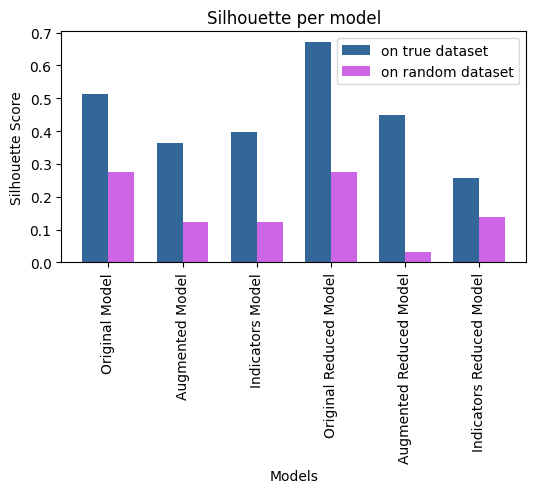

In [240]:
# assessment: comparing obtained models with random data models

values = [sil for sil in sils['Silhouette']]
plt.figure(figsize=(6, 3))
values_part1 = values[0:6]
values_part2 = values[6:12]

color_part1 = (0.2, 0.4, 0.6)
color_part2 = (0.8, 0.4, 0.9)

bar_width = 0.35
bar_positions_part1 = np.arange(len(model_names)/2)
bar_positions_part2 = bar_positions_part1 + bar_width

plt.bar(bar_positions_part1, values_part1, width=bar_width, color=color_part1, label='on true dataset')

plt.bar(bar_positions_part2, values_part2, width=bar_width, color=color_part2, label='on random dataset')

plt.xticks(bar_positions_part1 + bar_width / 2, model_names[0:6], rotation=90)
plt.xlabel('Models')
plt.ylabel('Silhouette Score')
plt.title('Silhouette per model')


plt.legend()
plt.show()

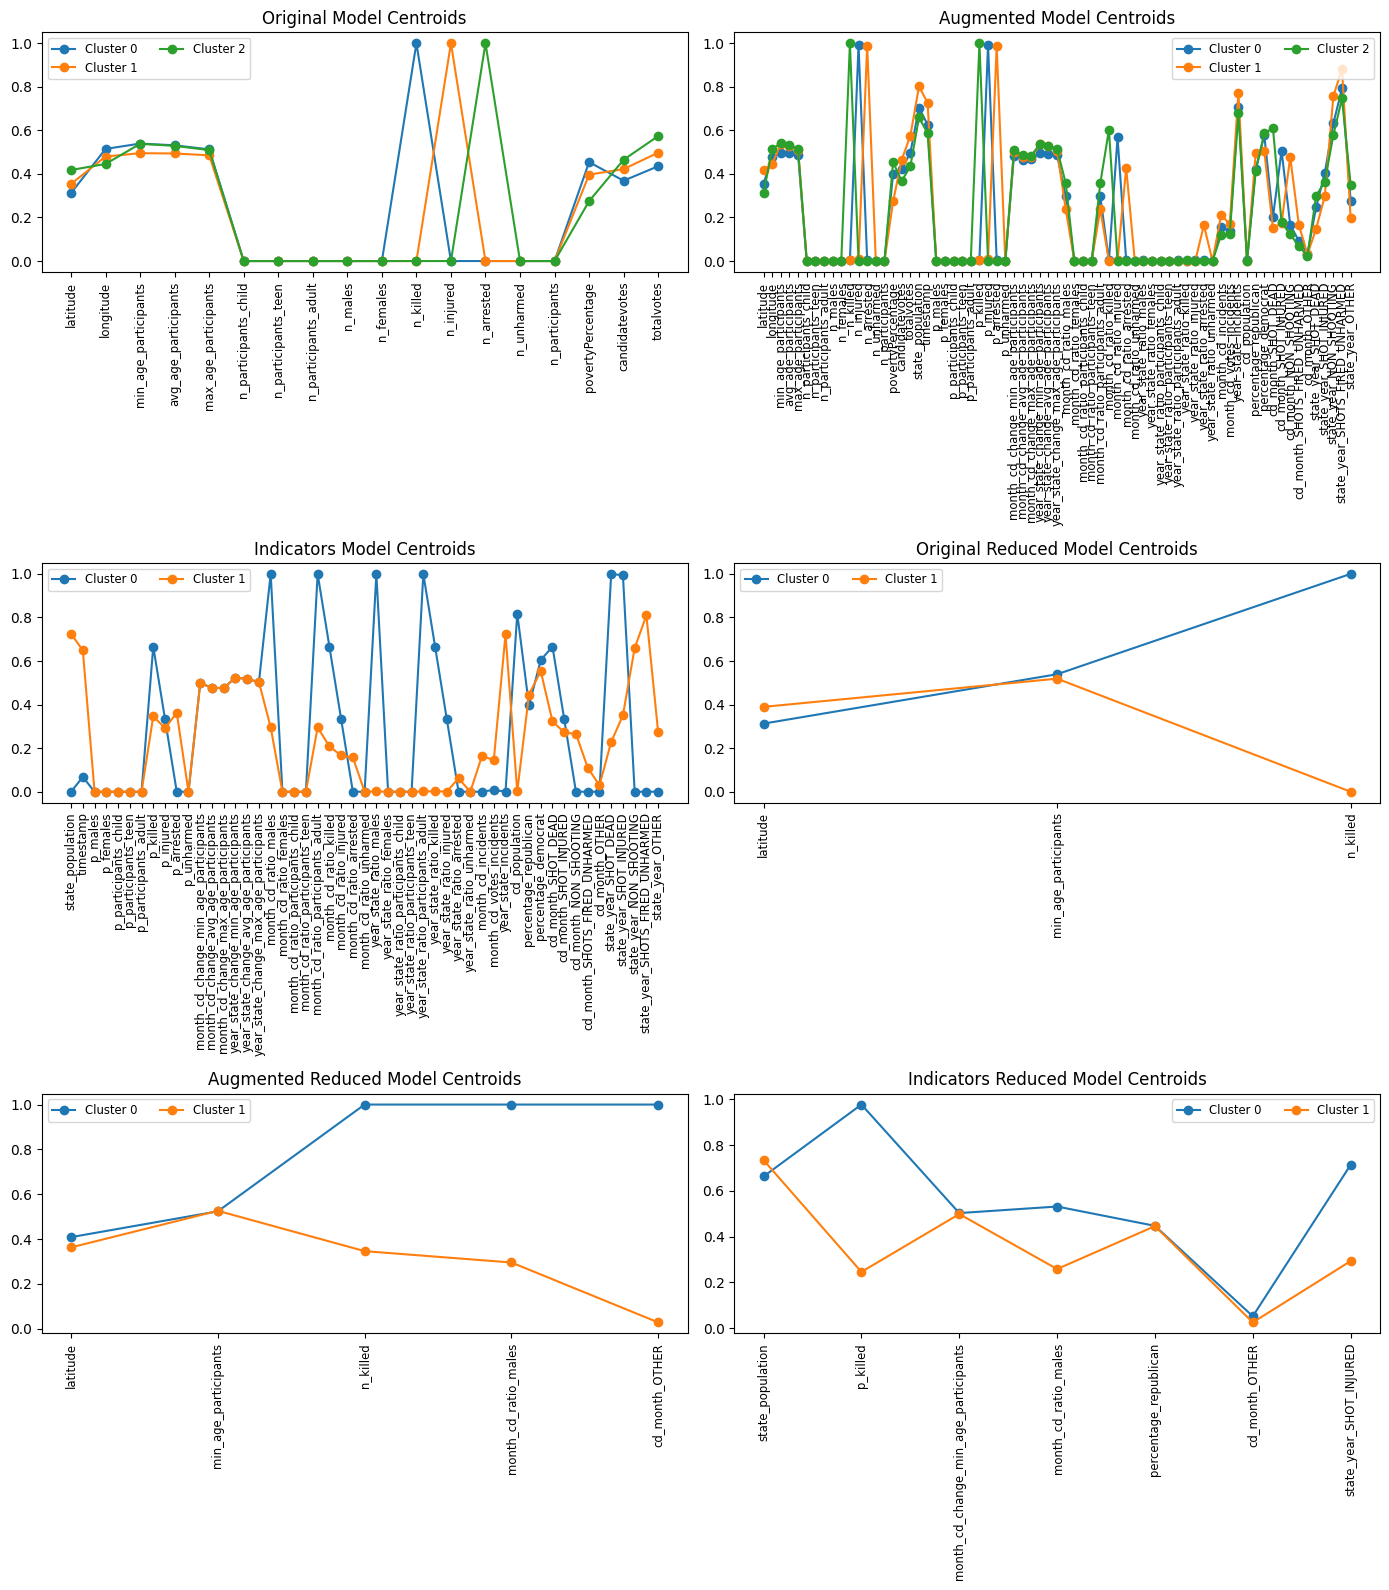

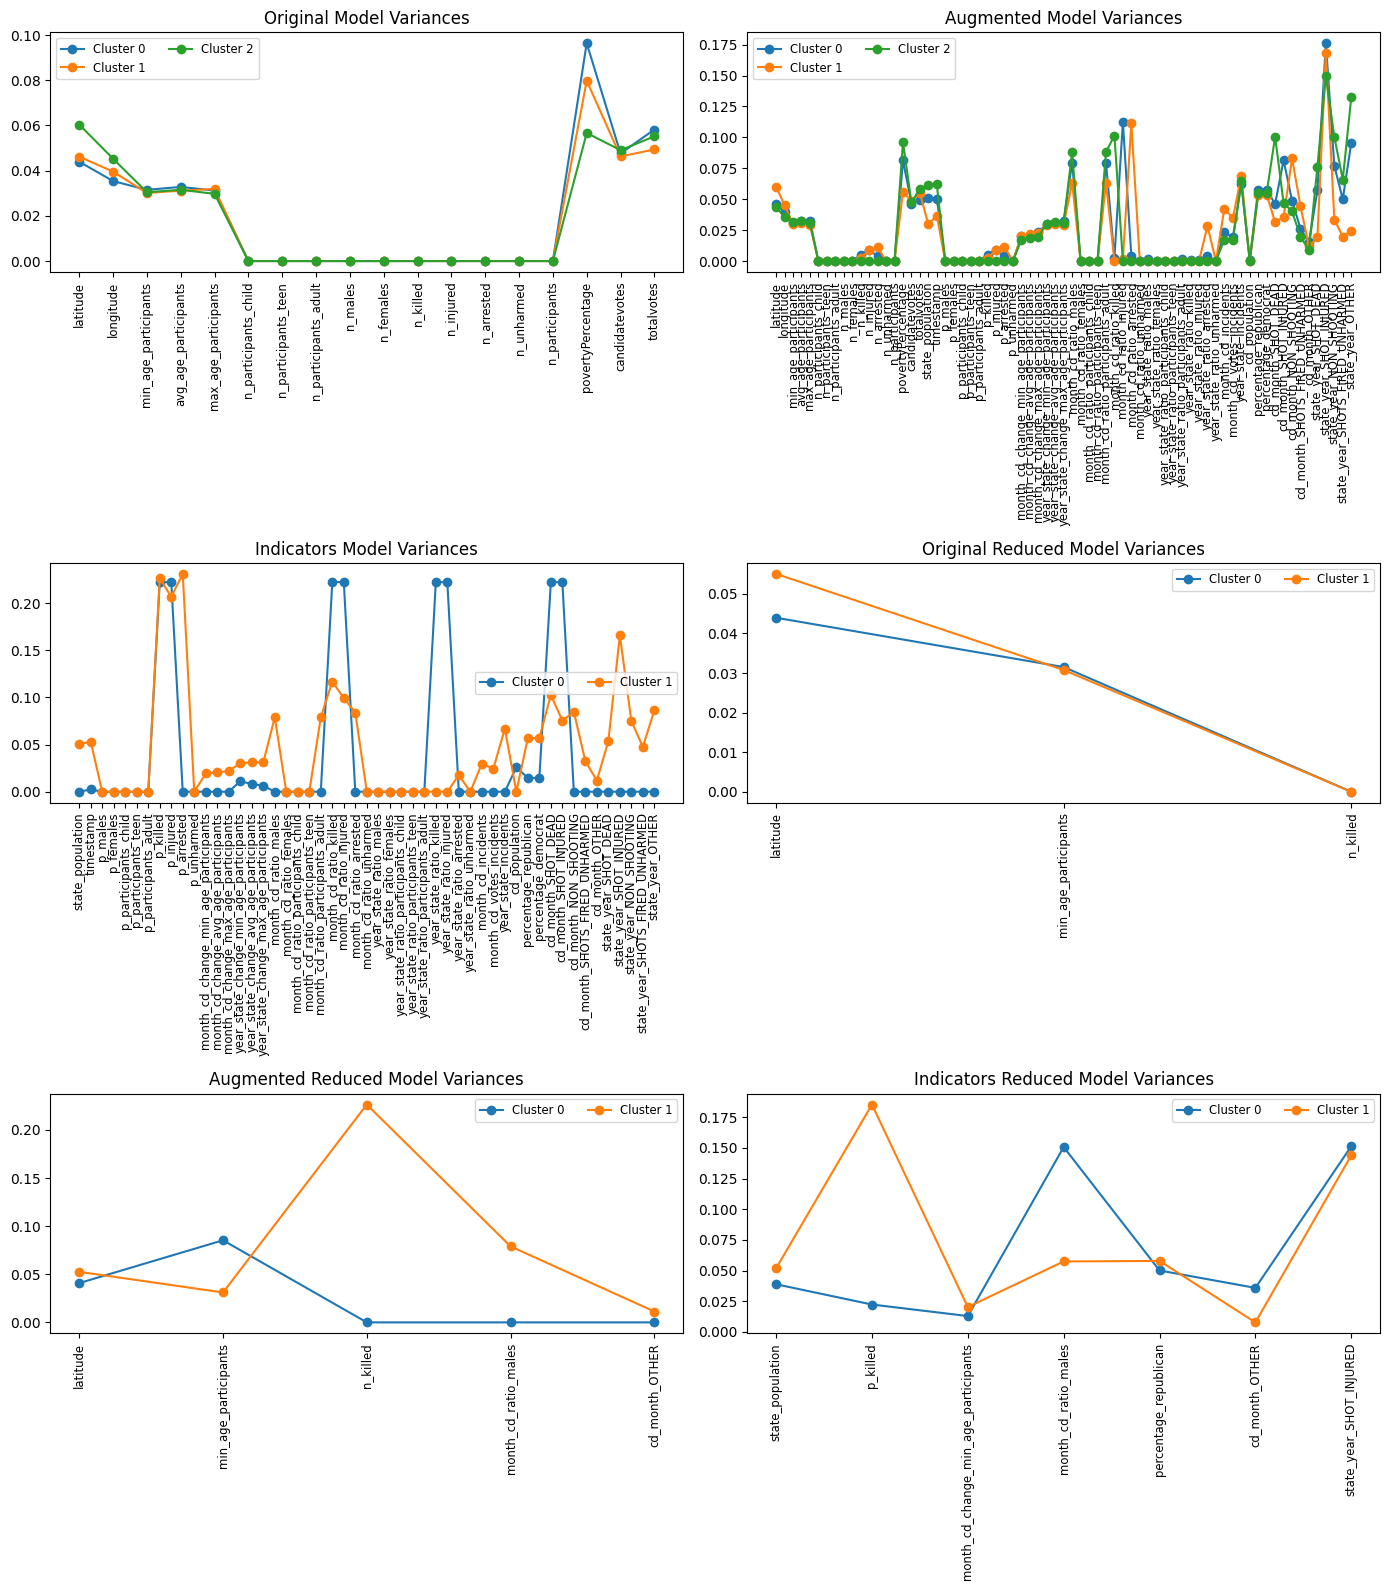

In [374]:
# plot centroids

all_meanss = []
all_variancess = []
for model, dataframe in zip(all_best_models, all_dataframes):
    points = dataframe.values
    labels = [l for l in model.labels_]
    means = []
    variances = []
    for cluster_label in np.unique(model.labels_):
        cluster = [points[i] for i in range(len(points)) if labels[i] == cluster_label]
        means.append(np.mean(cluster, axis=0))
        variances.append(np.var(cluster, axis=0))
    all_meanss.append(means)
    all_variancess.append(variances)

true_meanss = all_meanss[0:6]
random_meanss = all_meanss[6:12]

true_variancess = all_variancess[0:6]
random_variancess = all_variancess[6:12]

true_best_models = all_best_models[0:6]
random_best_models = all_best_models[6:12]

plt.figure(figsize=(14, 16))
N = len(true_best_models)

for i in range(N):
    model = true_best_models[i]
    cols = scaled_dataframes[i].columns
    means = true_meanss[i]
    plt.subplot(3, 2, i+1)
    plt.title(f'{model_names[i]} Centroids')
    for z in range(len(means)):
        plt.plot(means[z], marker='o', label=f'Cluster {z}')
        plt.xticks(range(len(cols)), cols, rotation=90, fontsize='small')
        plt.legend(fontsize='small', ncol=2)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 16))
for i in range(N):
    model = true_best_models[i]
    cols = scaled_dataframes[i].columns
    variances = true_variancess[i]
    plt.subplot(3, 2, i+1)
    plt.title(f'{model_names[i]} Variances')
    for z in range(len(variances)):
        plt.plot(variances[z], marker='o', label=f'Cluster {z}')
        plt.xticks(range(len(cols)), cols, rotation=90, fontsize='small')
        plt.legend(fontsize='small', ncol=2)
plt.tight_layout()
plt.show()

In [388]:
# plot attributes with low variance inside each cluster and that present enough different values between at least 2 centroids

N = len(true_best_models)
for i in range(N):
    model = true_best_models[i]
    means = true_meanss[i]
    variances = true_variancess[i]
    cols = scaled_dataframes[i].columns
    model_name = model_names[i]
    l = ''.join(['-' for j in range(50-len(model_name))])
    print(f'{model_name}{l}')
    dists = []
    for mean1 in means:
        for mean2 in means:
            dists.append(np.abs(mean1-mean2))
    model_vars = np.var(means, axis=0)
    for z in range(len(cols)):
        max_dist = np.max([d[z] for d in dists])
        if max_dist > 0.5:
            if False not in [variances[j][z] < 0.1 for j in range(len(variances))]:
                print(cols[z])

Original Model------------------------------------
n_killed
n_injured
n_arrested
Augmented Model-----------------------------------
n_killed
n_injured
n_arrested
p_killed
p_injured
p_arrested
Indicators Model----------------------------------
state_population
timestamp
month_cd_ratio_males
month_cd_ratio_participants_adult
year_state_ratio_males
year_state_ratio_participants_adult
year_state_incidents
cd_population
state_year_SHOT_DEAD
state_year_NON_SHOOTING
state_year_SHOTS_FIRED_UNHARMED
Original Reduced Model----------------------------
n_killed
Augmented Reduced Model---------------------------
month_cd_ratio_males
cd_month_OTHER
Indicators Reduced Model--------------------------


/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with f

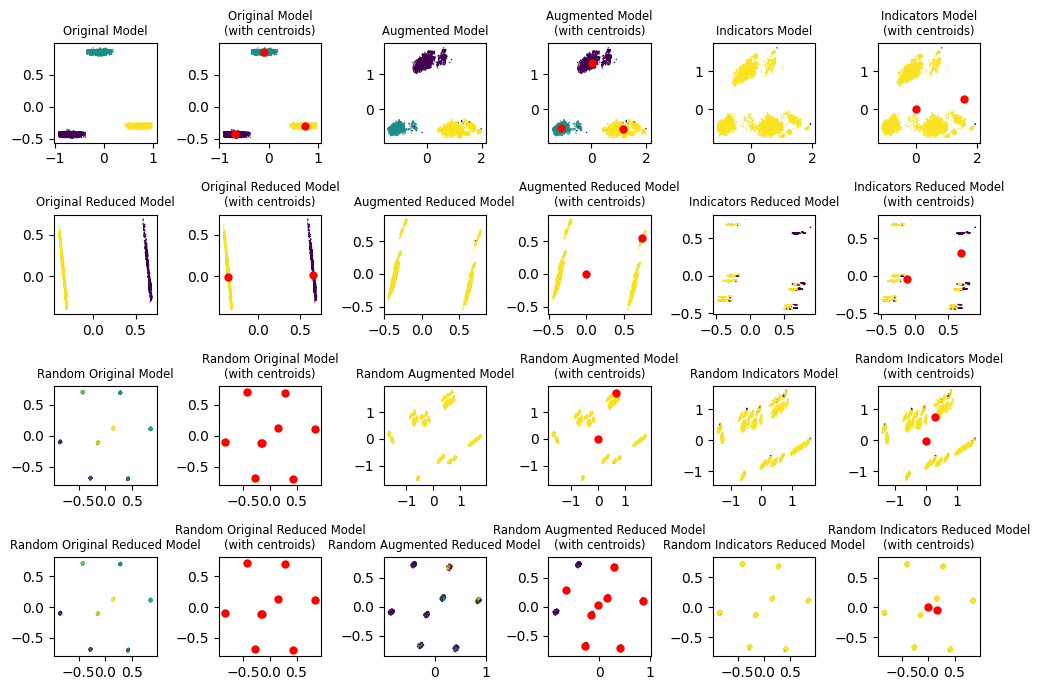

In [400]:
# PCA visualization of clustering

plt.figure(figsize=(10, 7))
N = len(all_best_models)
for i, j in zip(range(N), np.arange(1, N*2, 2)):
    model = all_best_models[i]
    data = all_dataframes[i]

    plt.subplot(4, 6, j)
    plt.title(model_names[i], fontsize='small')
    pca_d, pca_c = perform_PCA(df=data, n_components=2, centroids=all_meanss[i])
    plt.scatter(pca_d[:, 0], pca_d[:, 1], c=model.labels_, s=1, edgecolors='black', linewidths=0.001)

    plt.subplot(4, 6, j+1)
    plt.title(f'{model_names[i]}\n(with centroids)', fontsize='small')
    pca_d, pca_c = perform_PCA(df=data, n_components=2, centroids=all_meanss[i])
    plt.scatter(pca_d[:, 0], pca_d[:, 1], c=model.labels_, s=1, edgecolors='black', linewidths=0.001)
    plt.scatter(pca_c[:, 0], pca_c[:, 1], c='red', edgecolors='black', linewidths=0.001)

plt.tight_layout()
plt.show()

Original Model


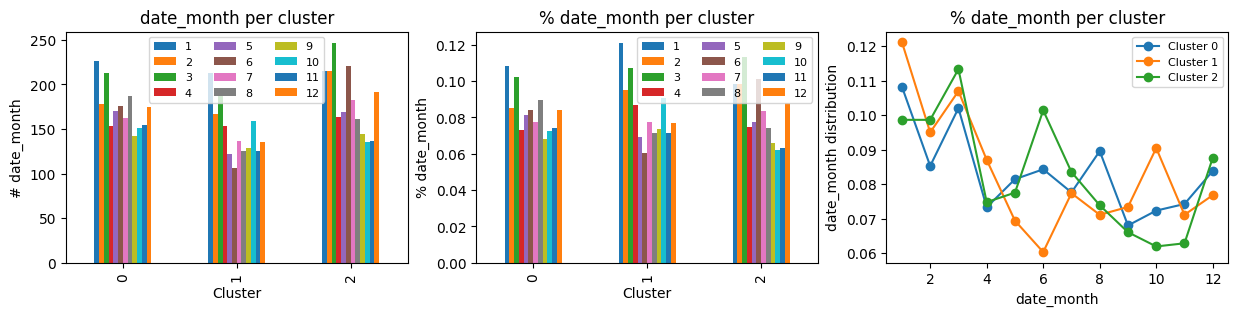

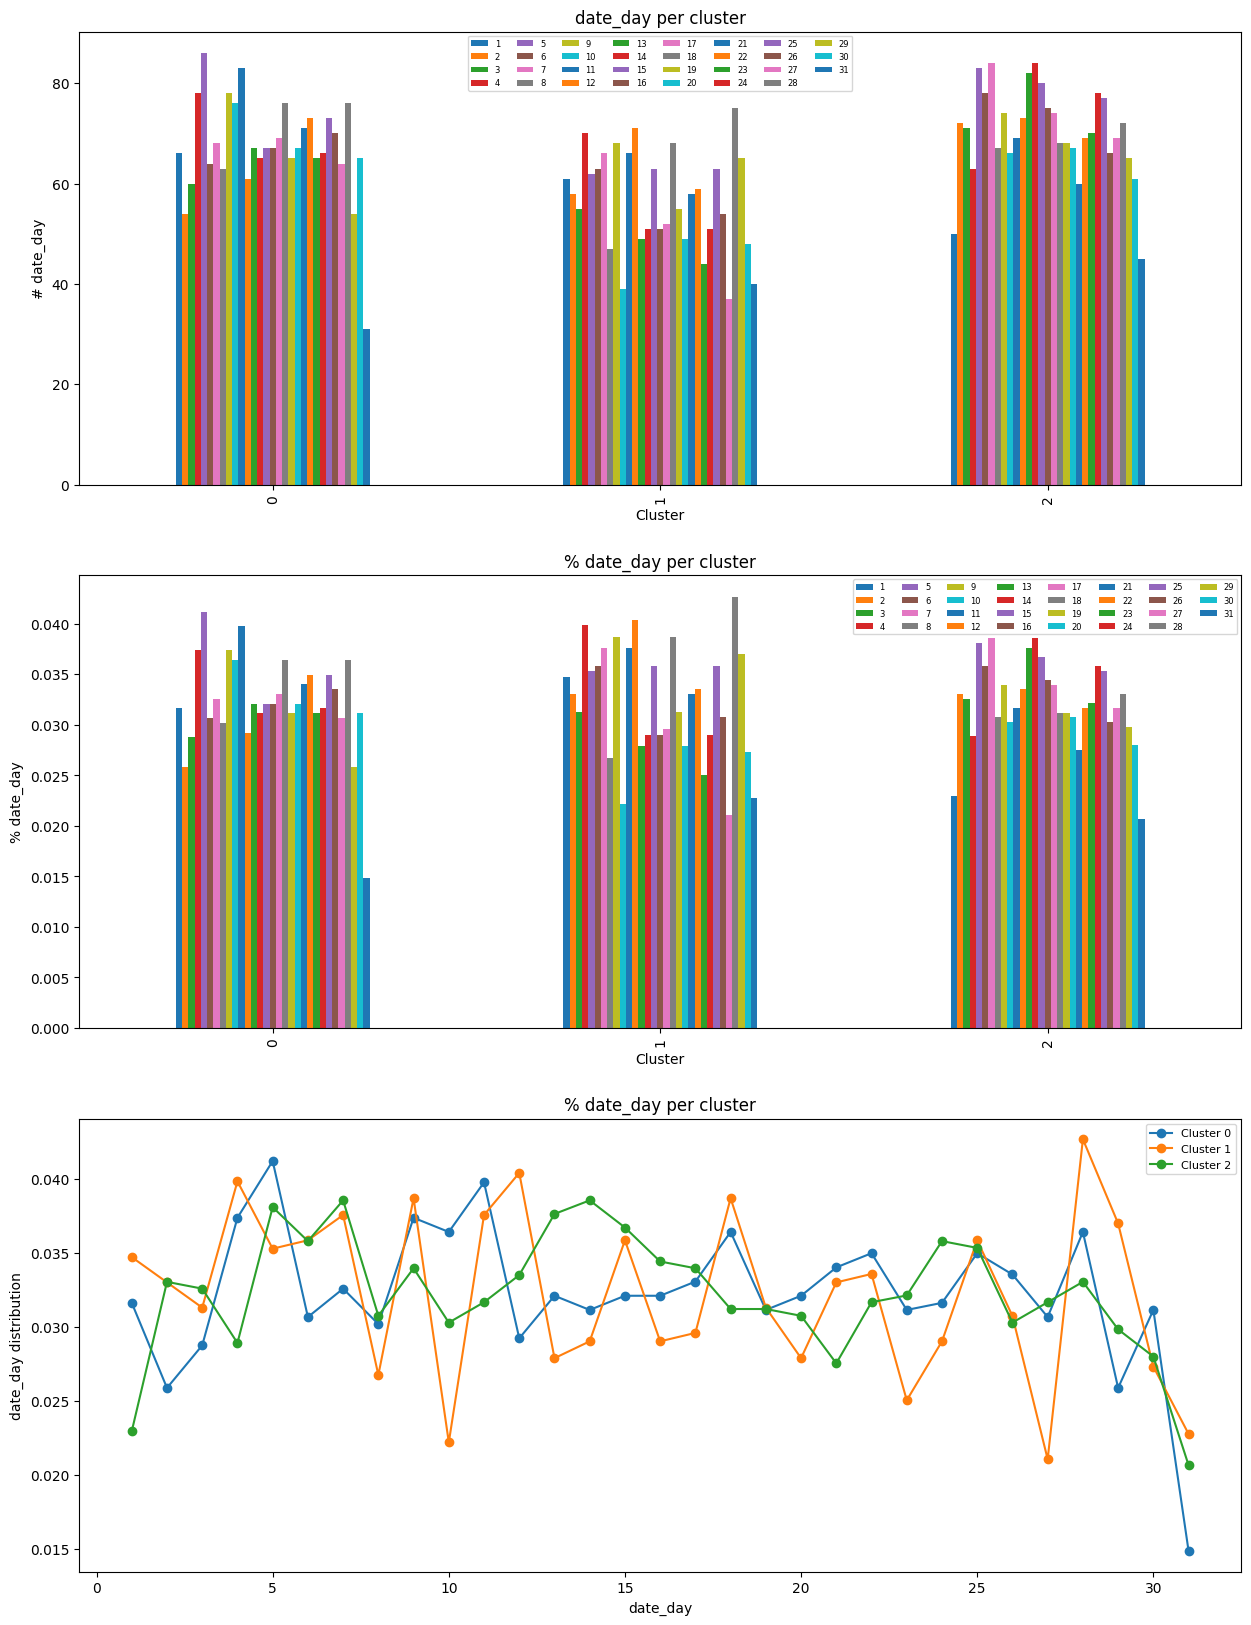

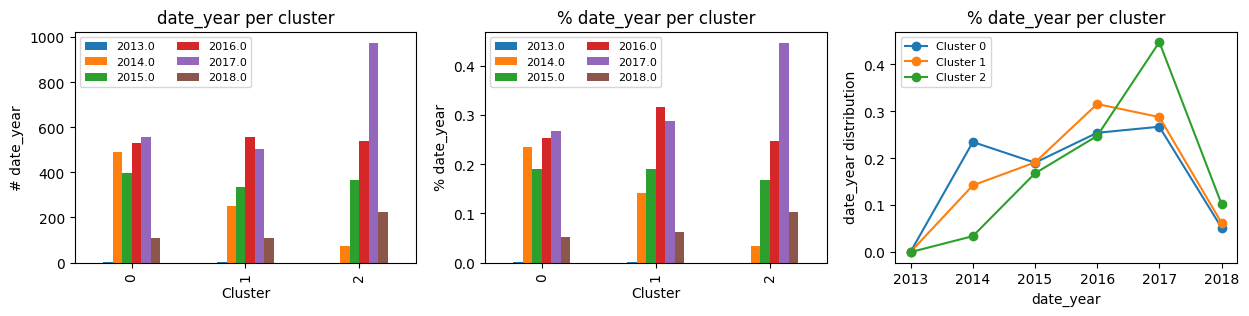

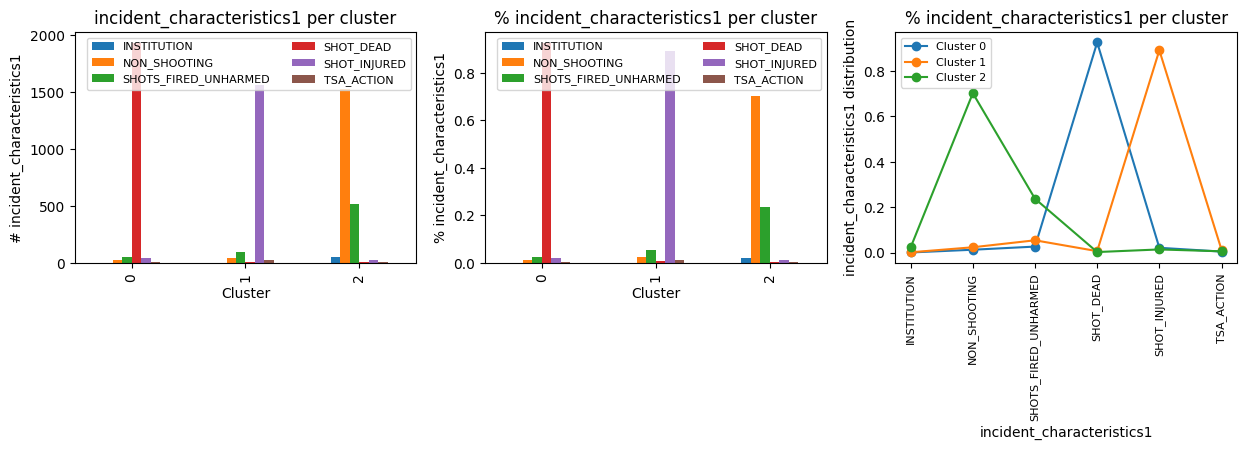

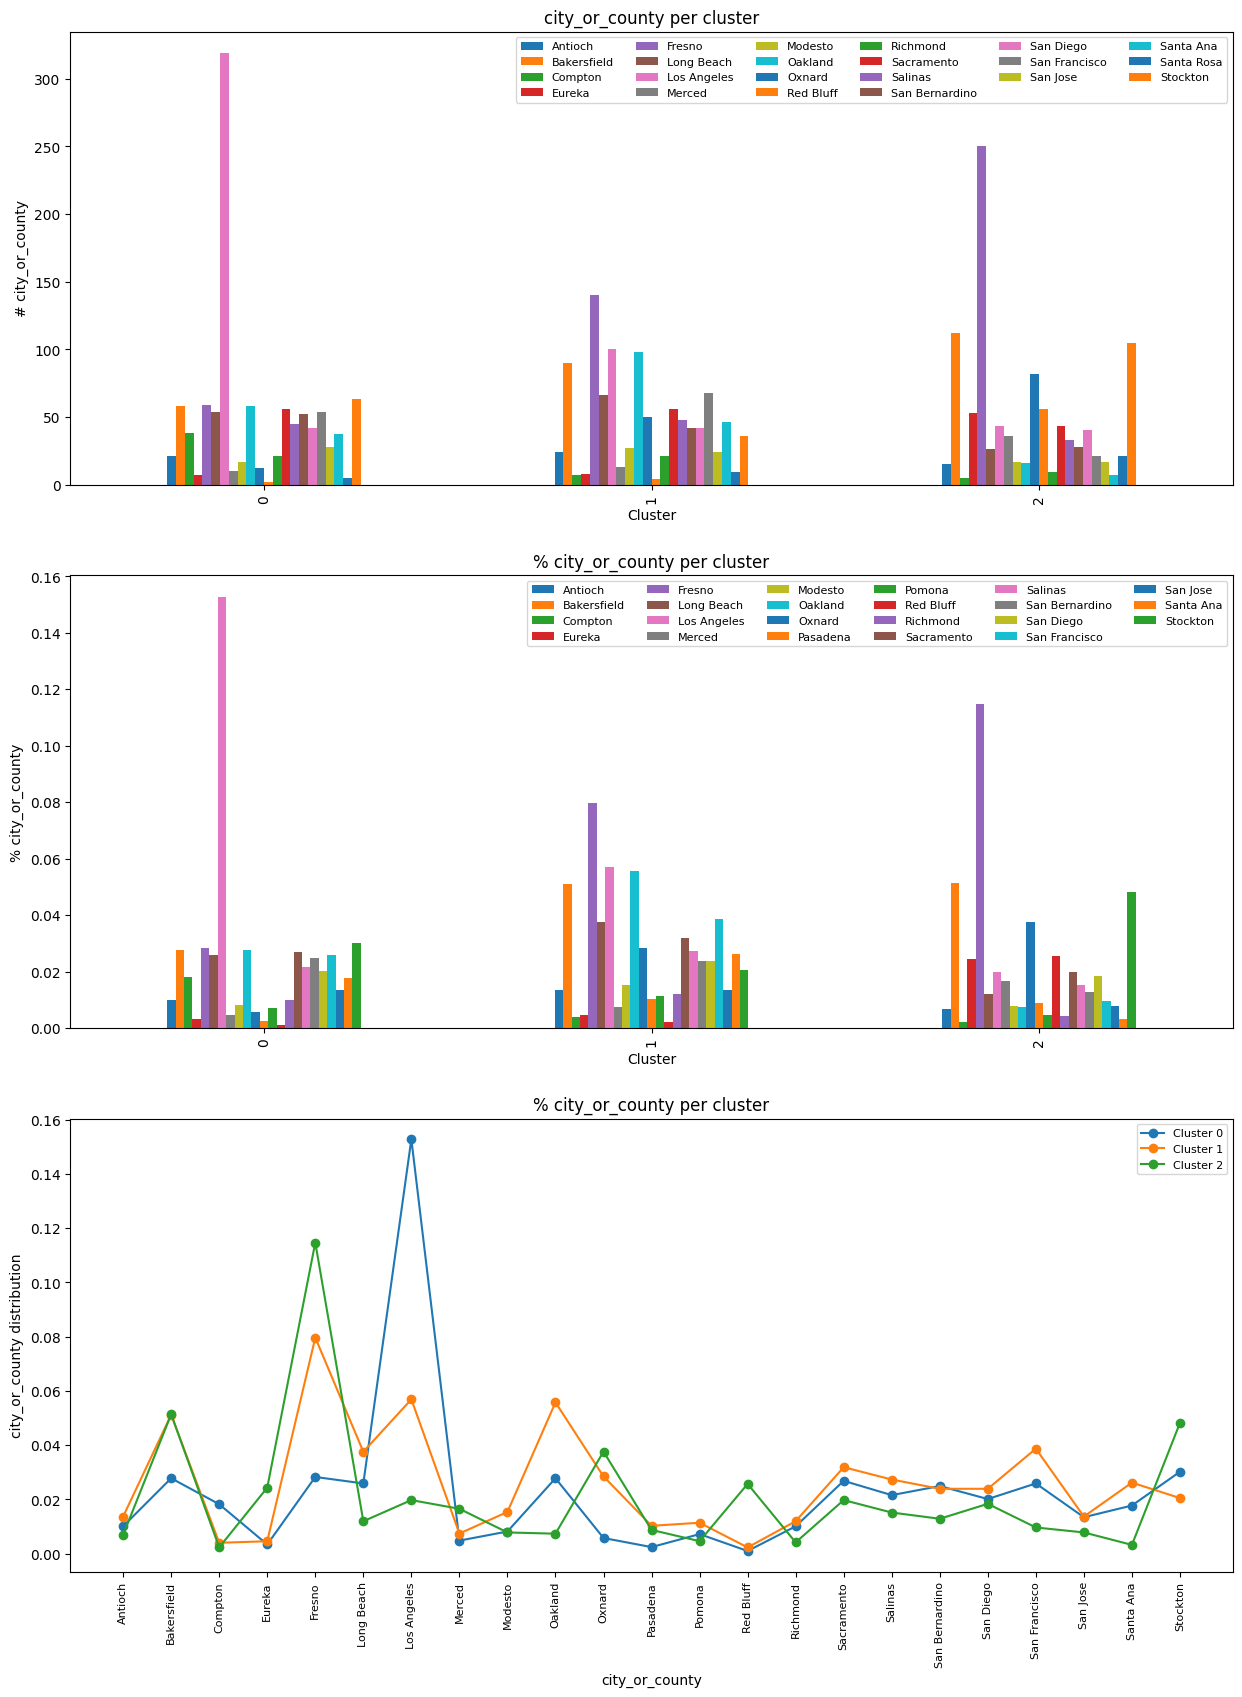

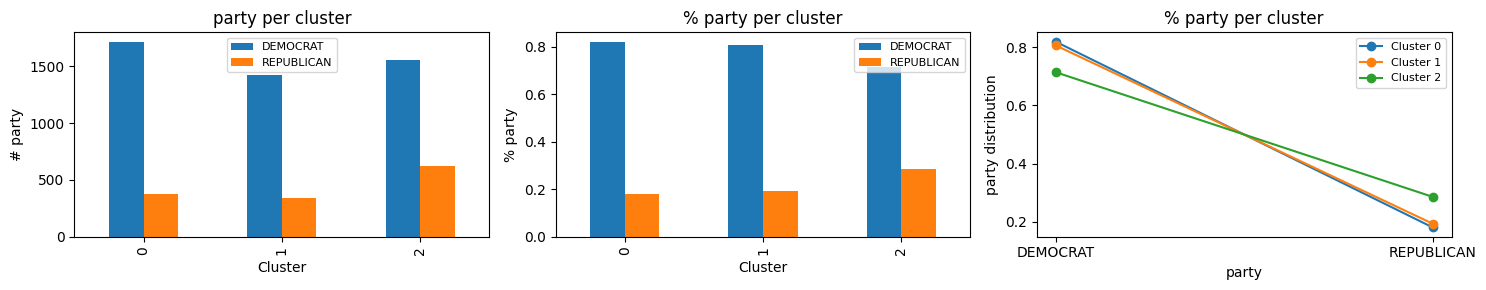

Augmented Model


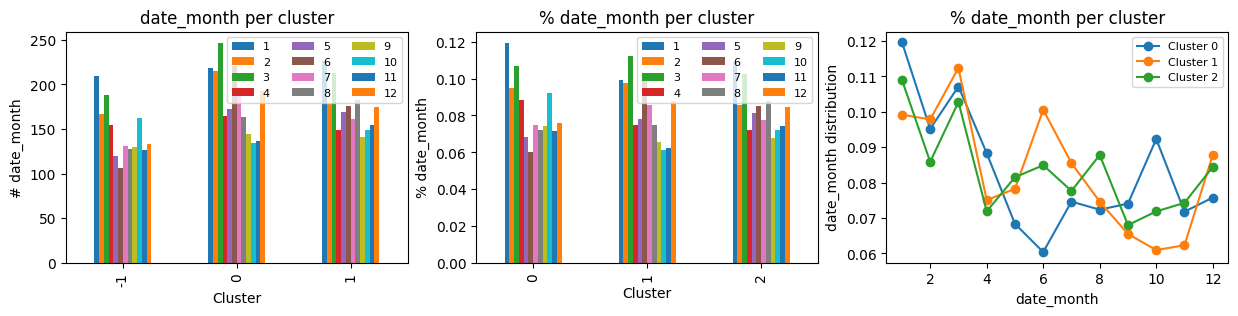

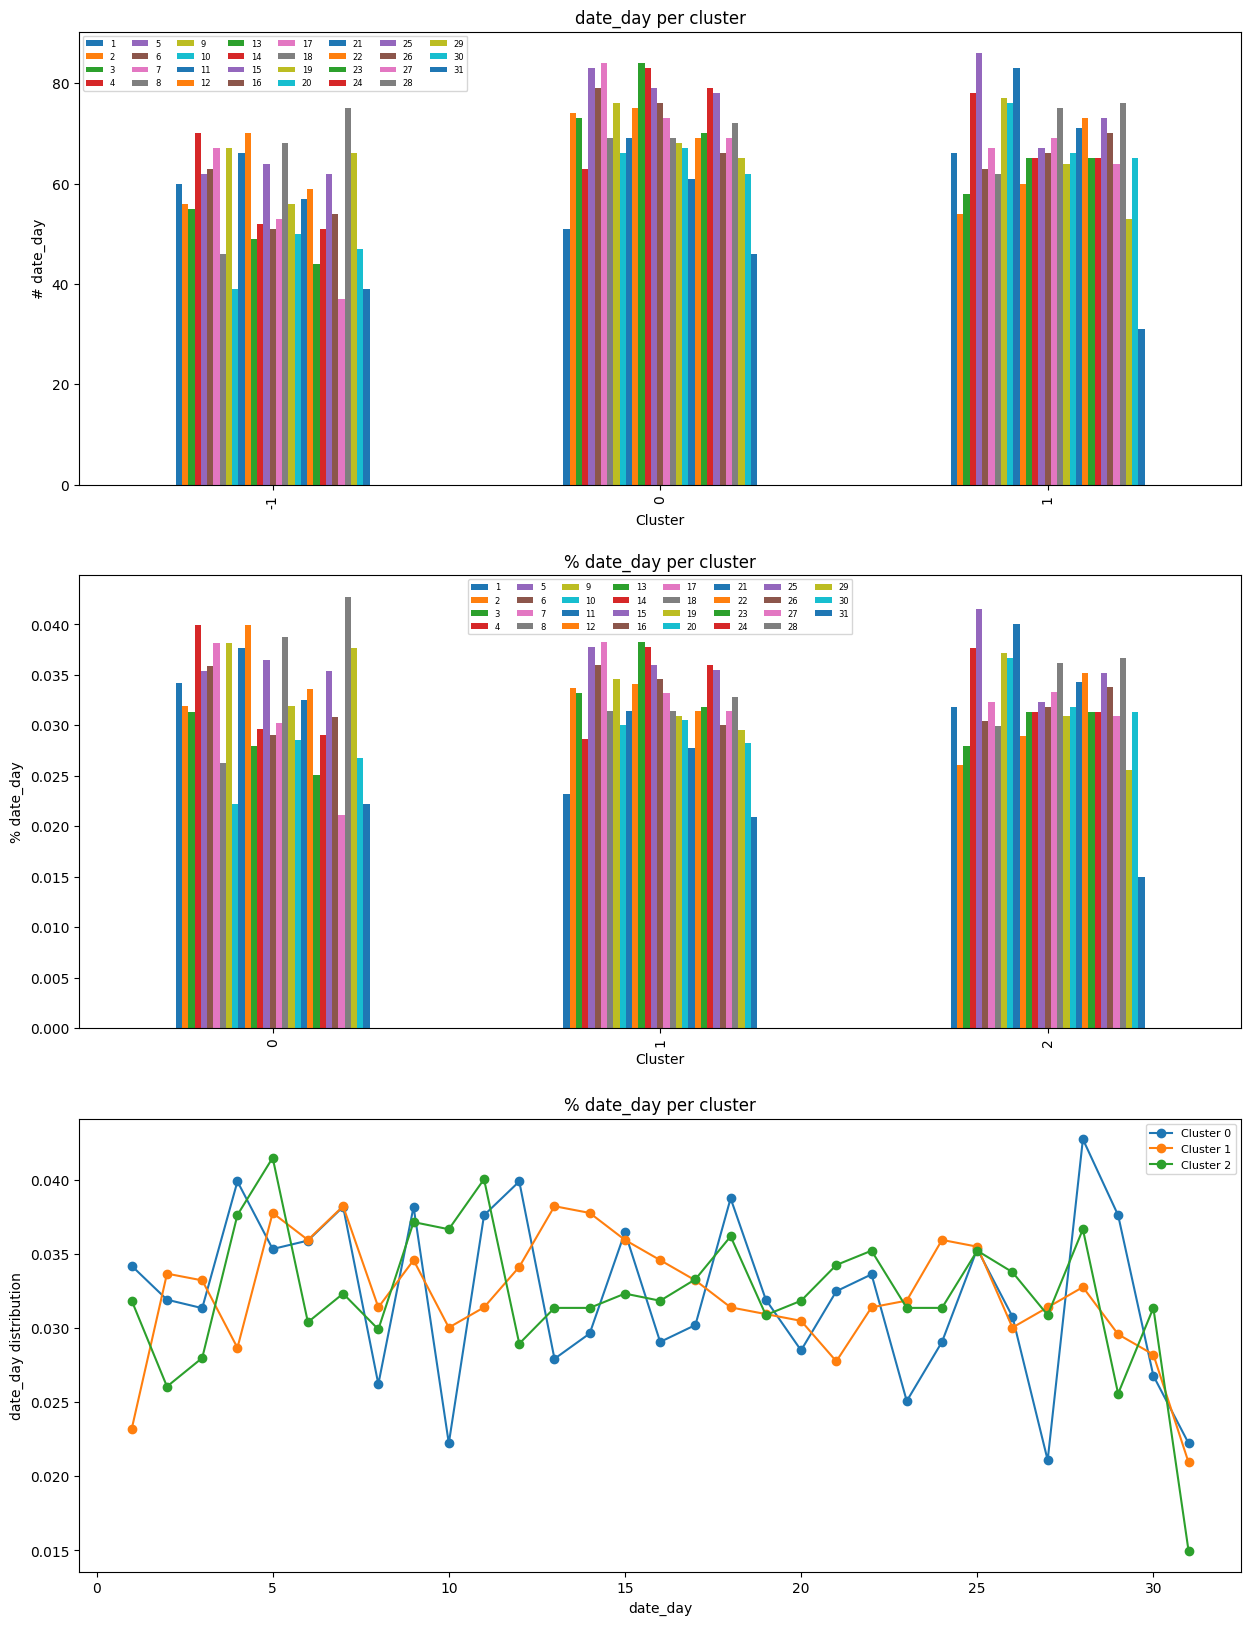

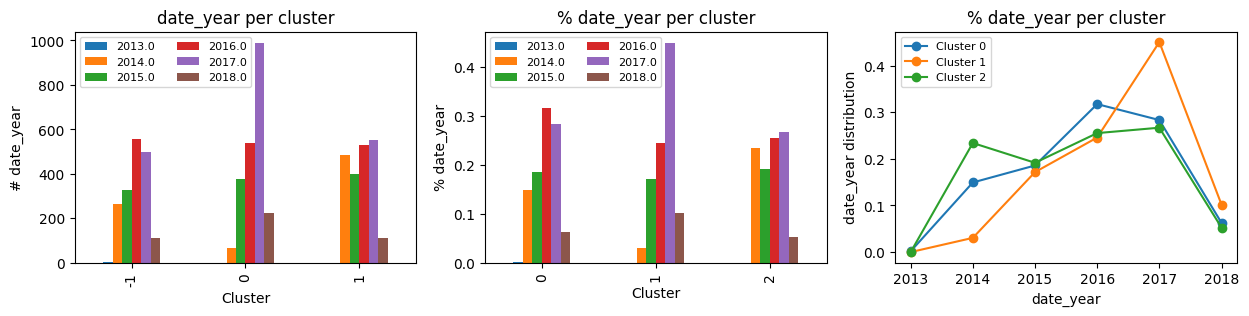

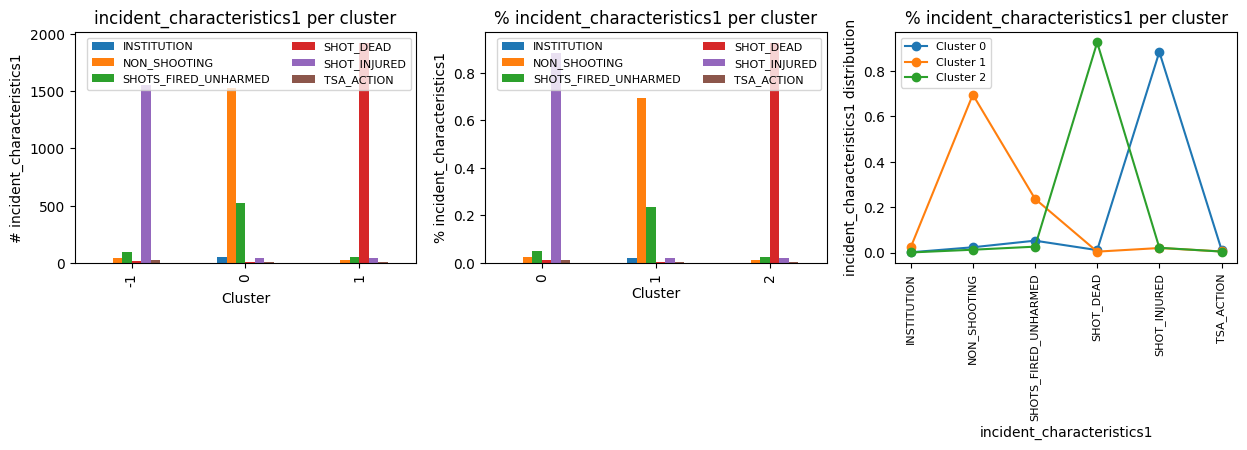

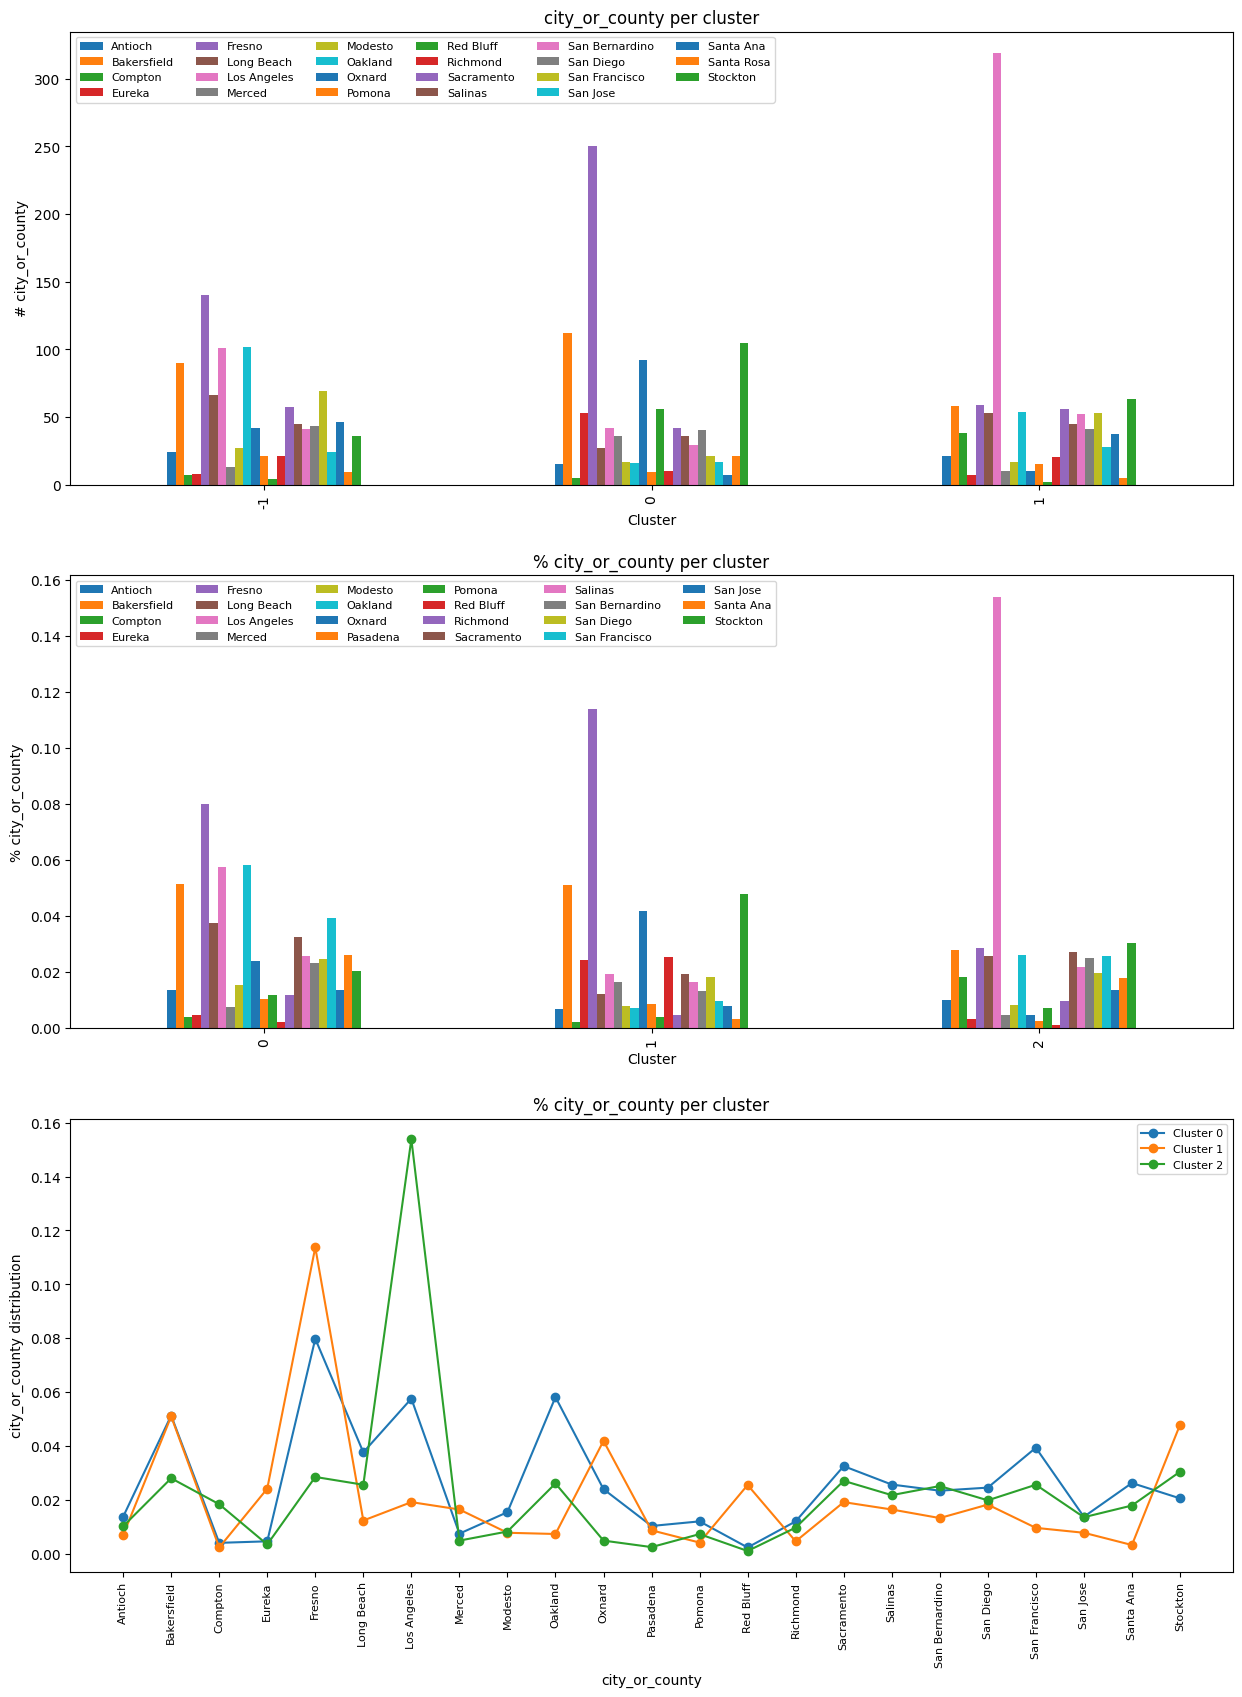

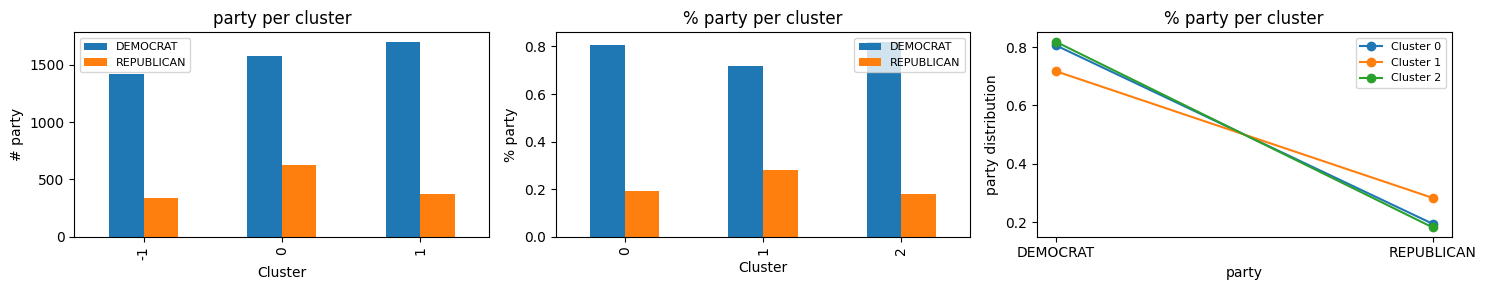

Indicators Model


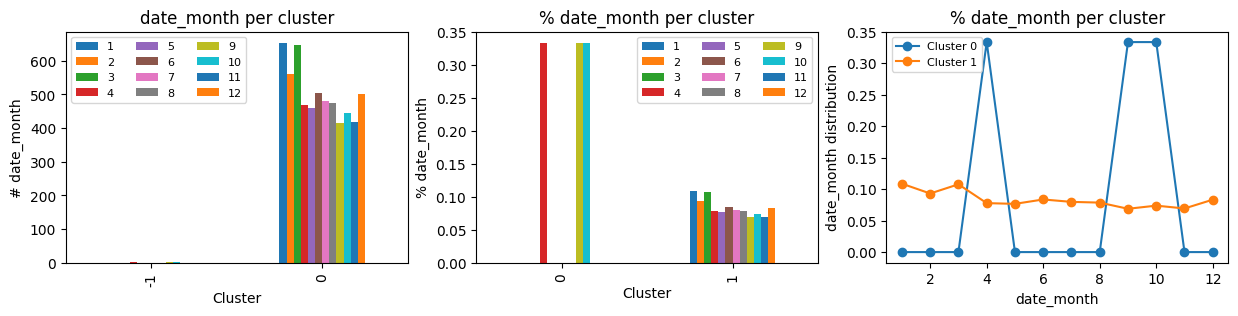

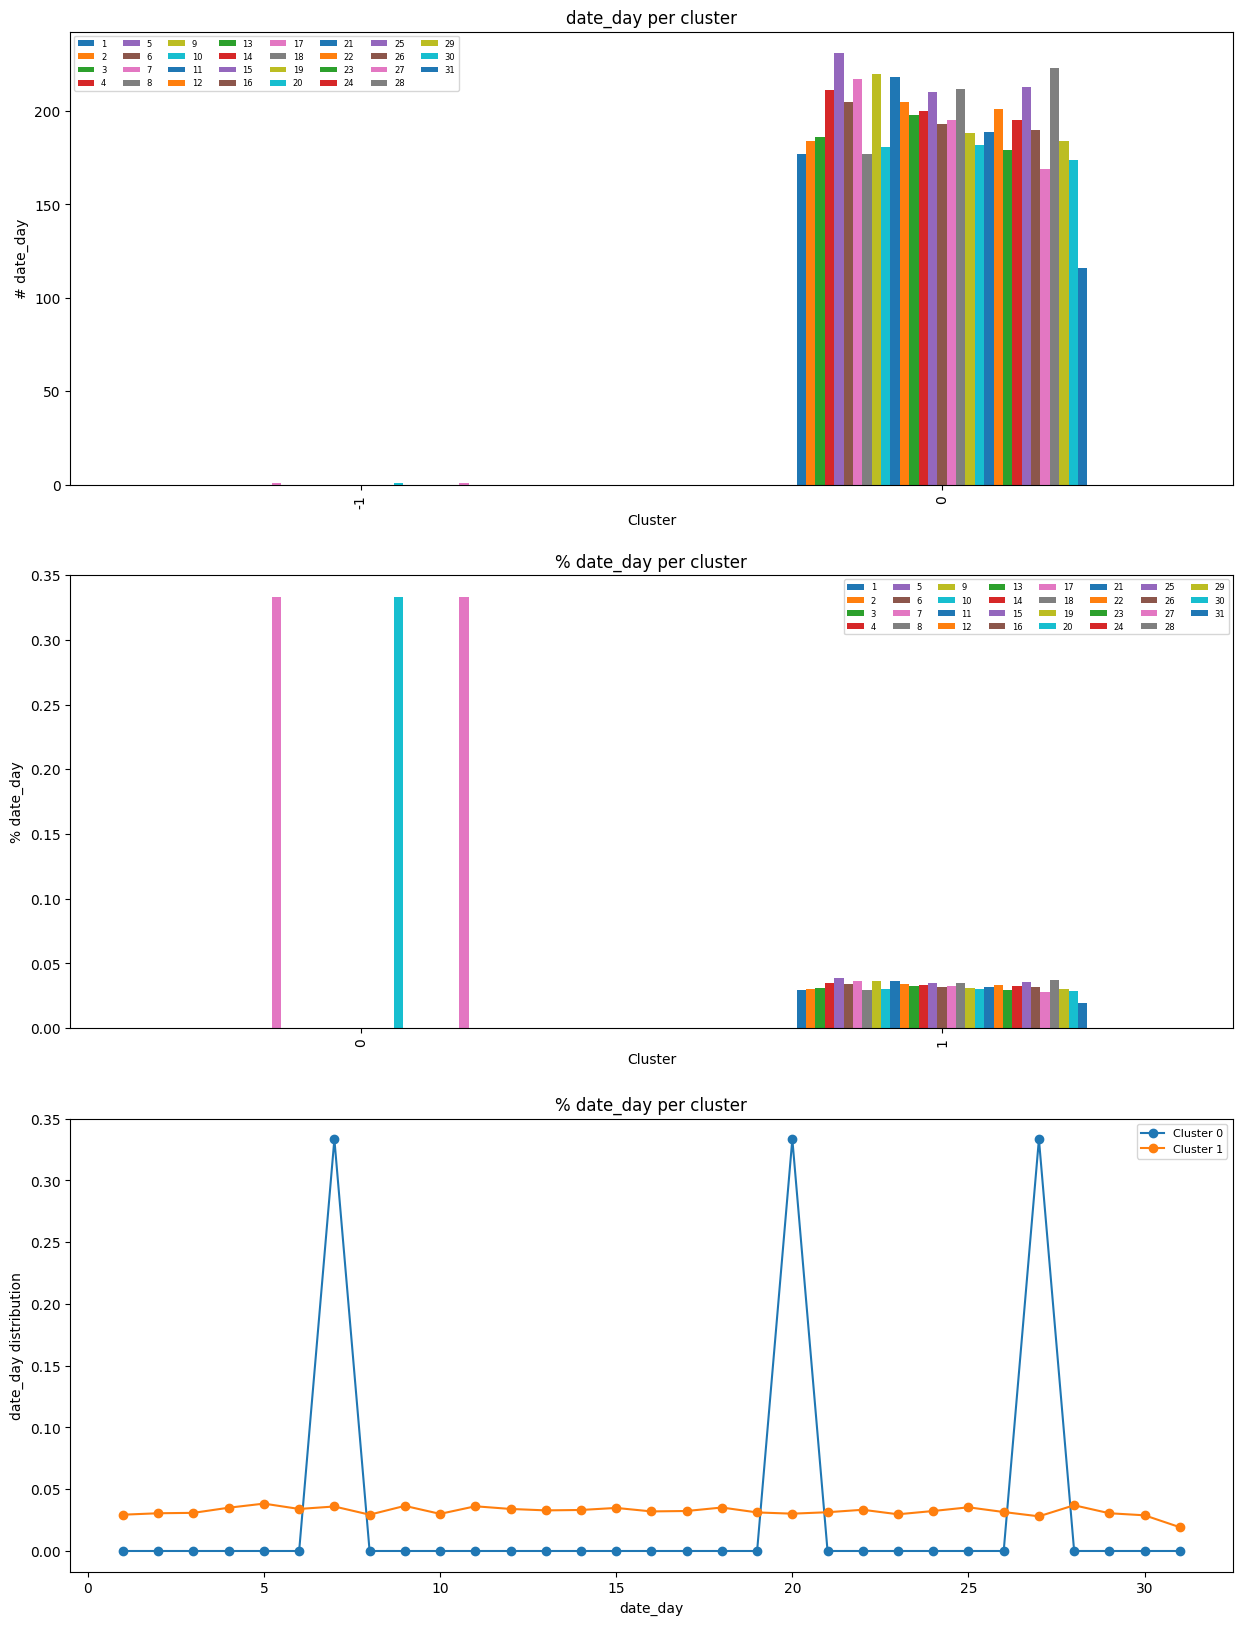

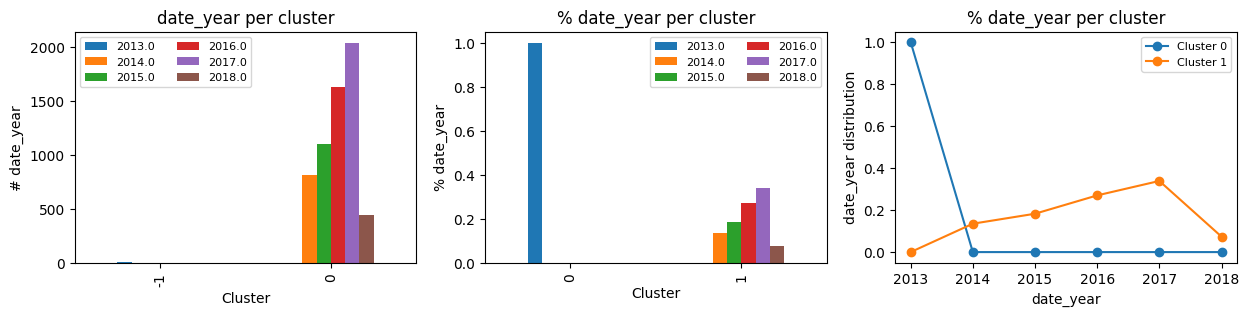

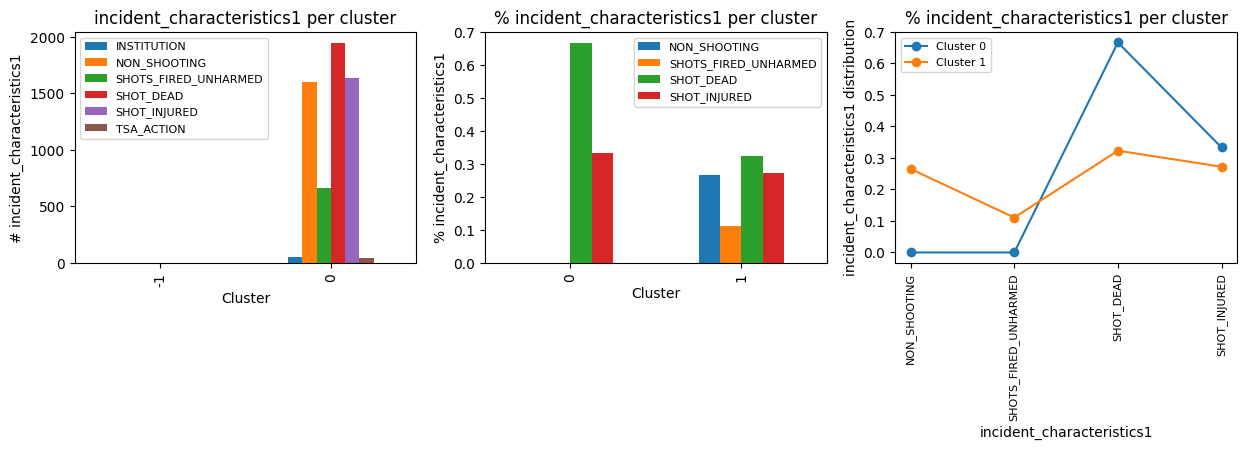

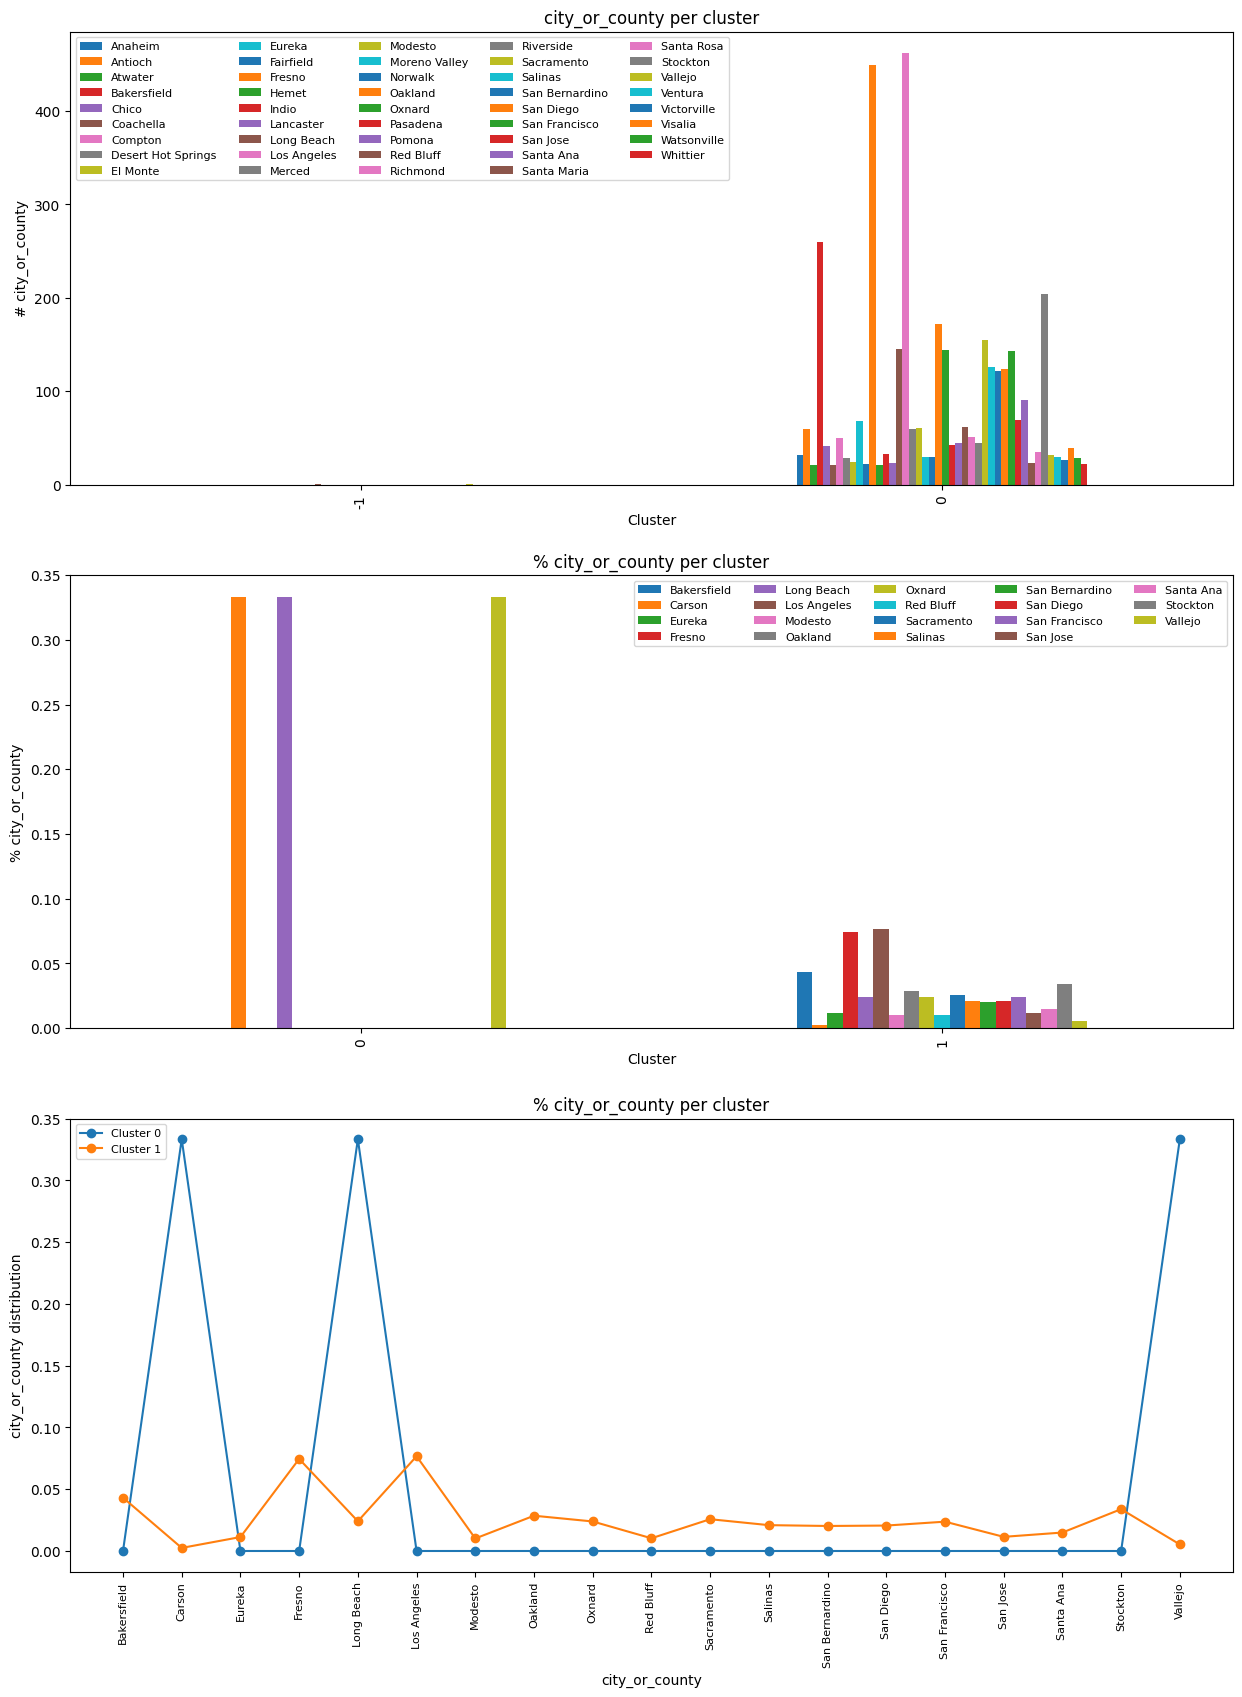

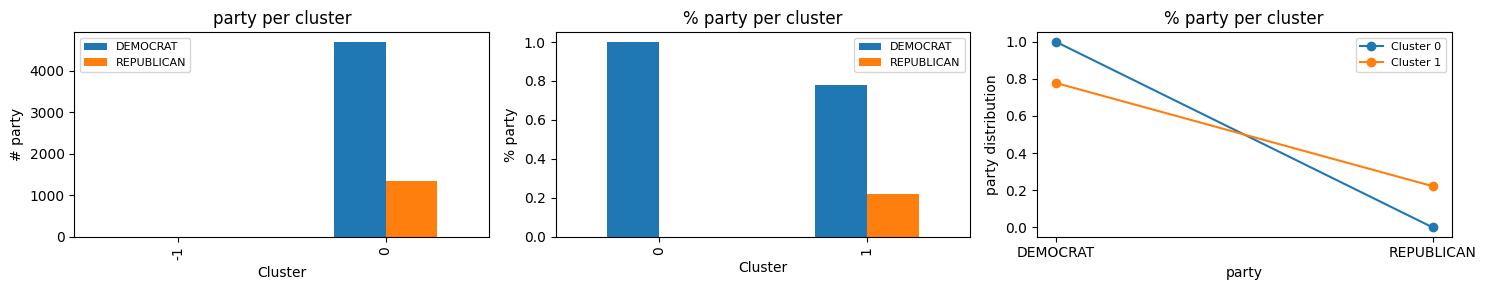

Original Reduced Model


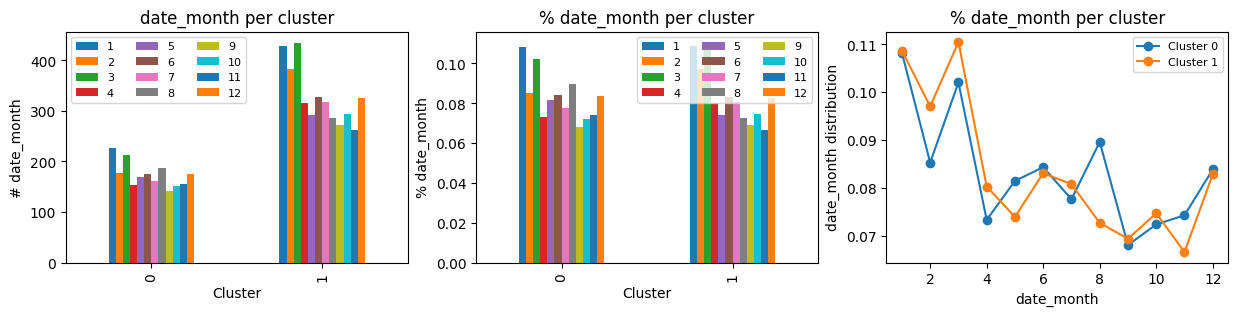

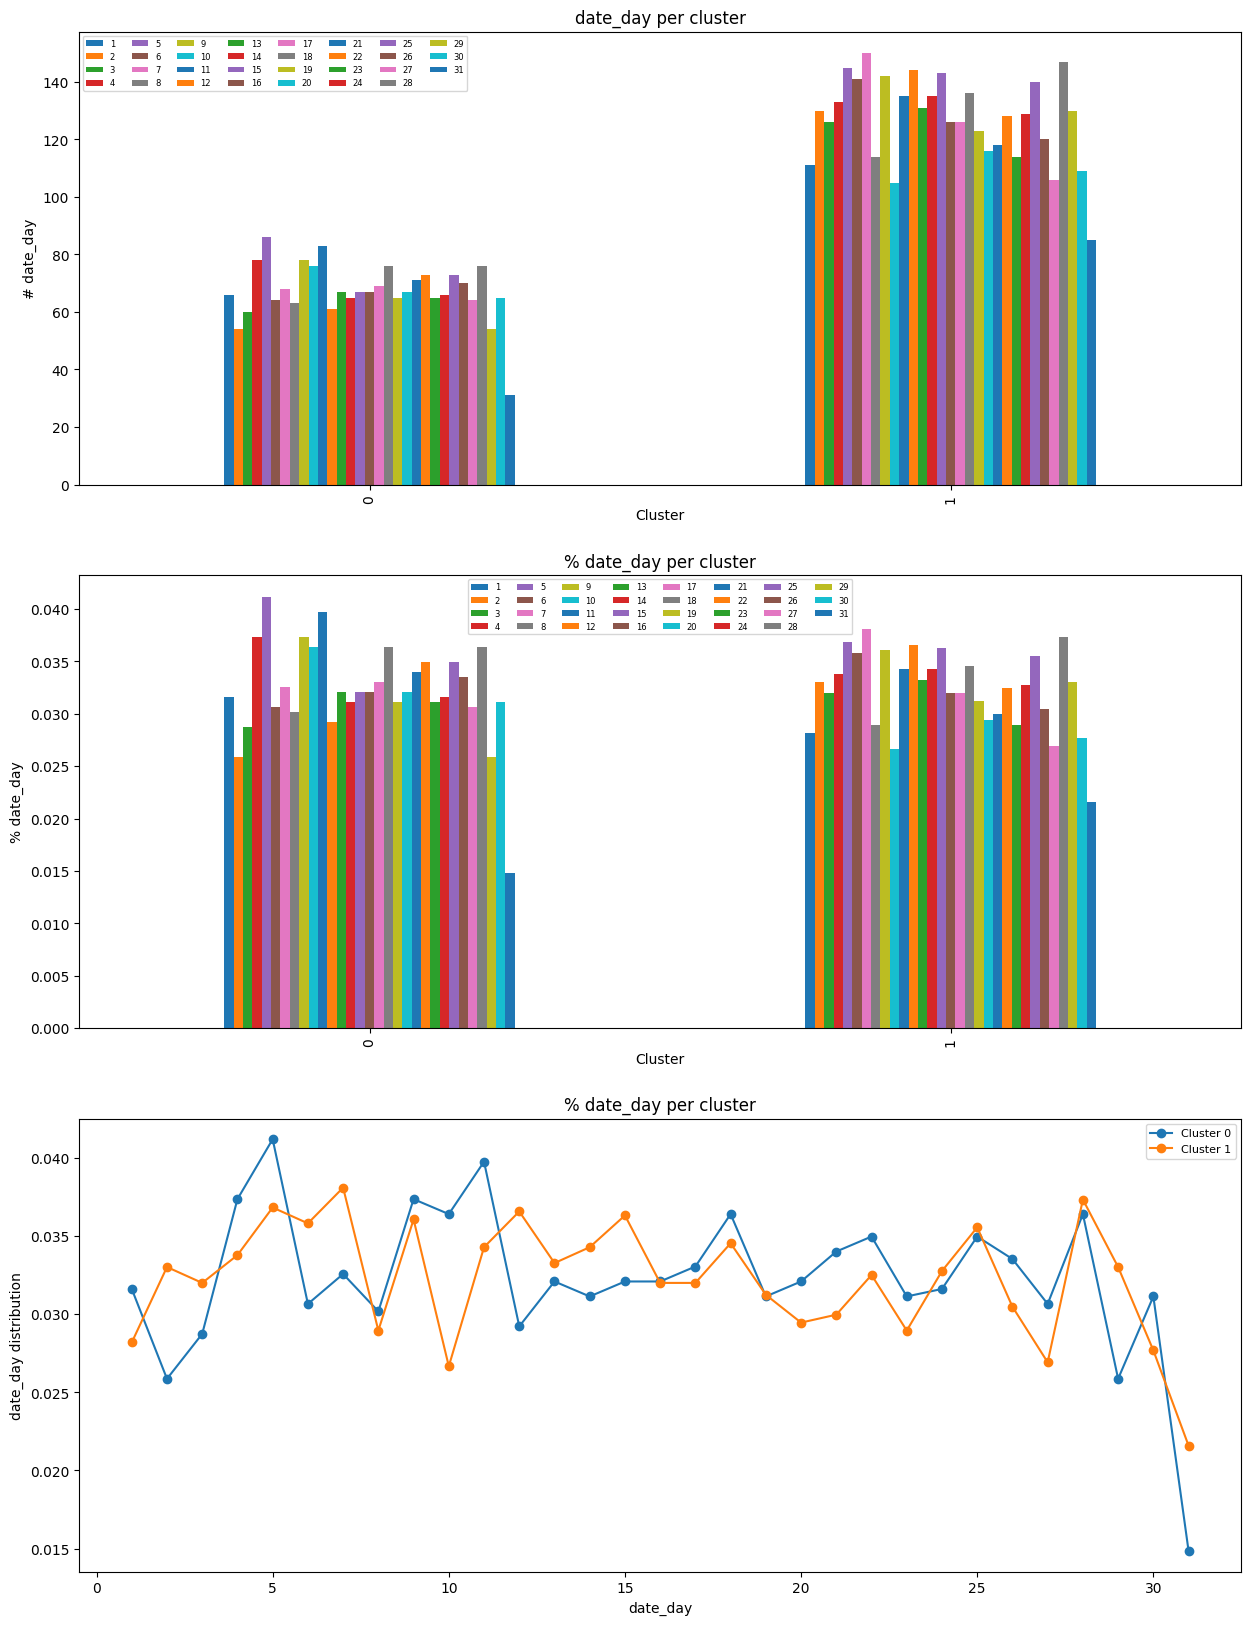

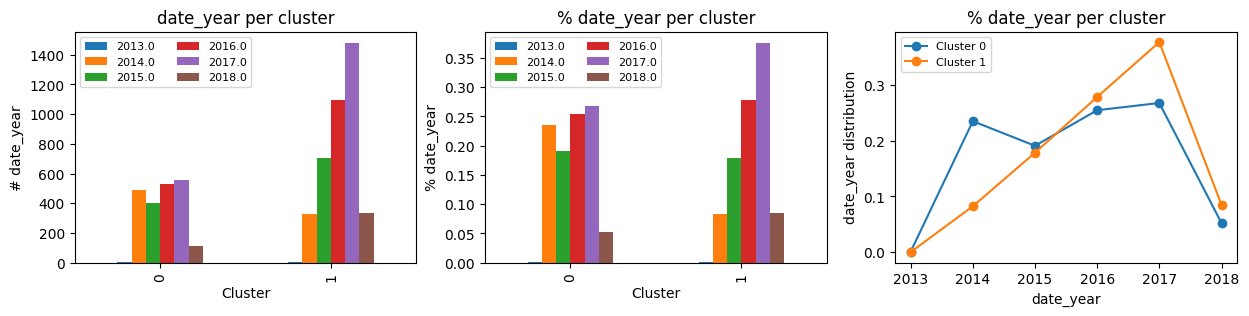

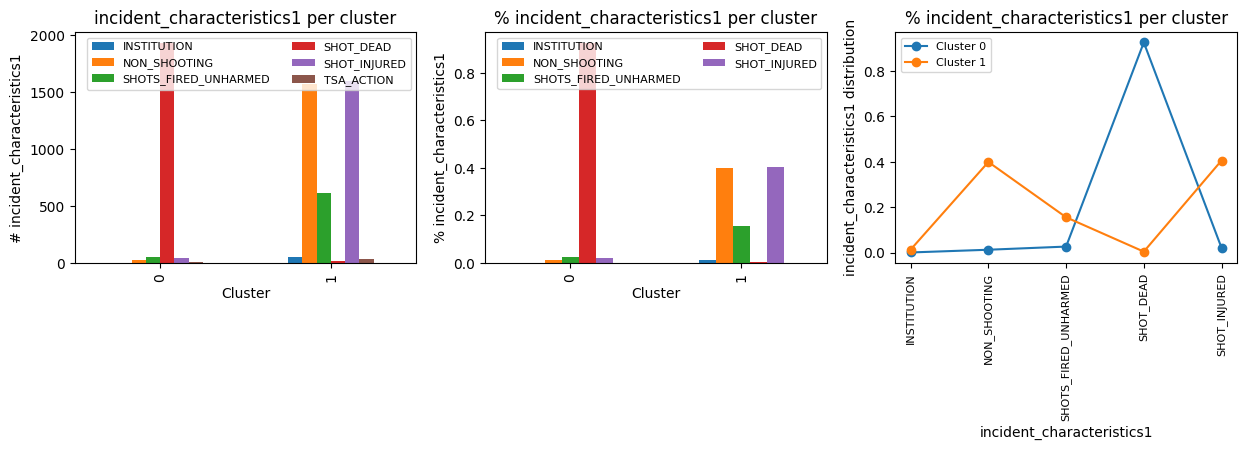

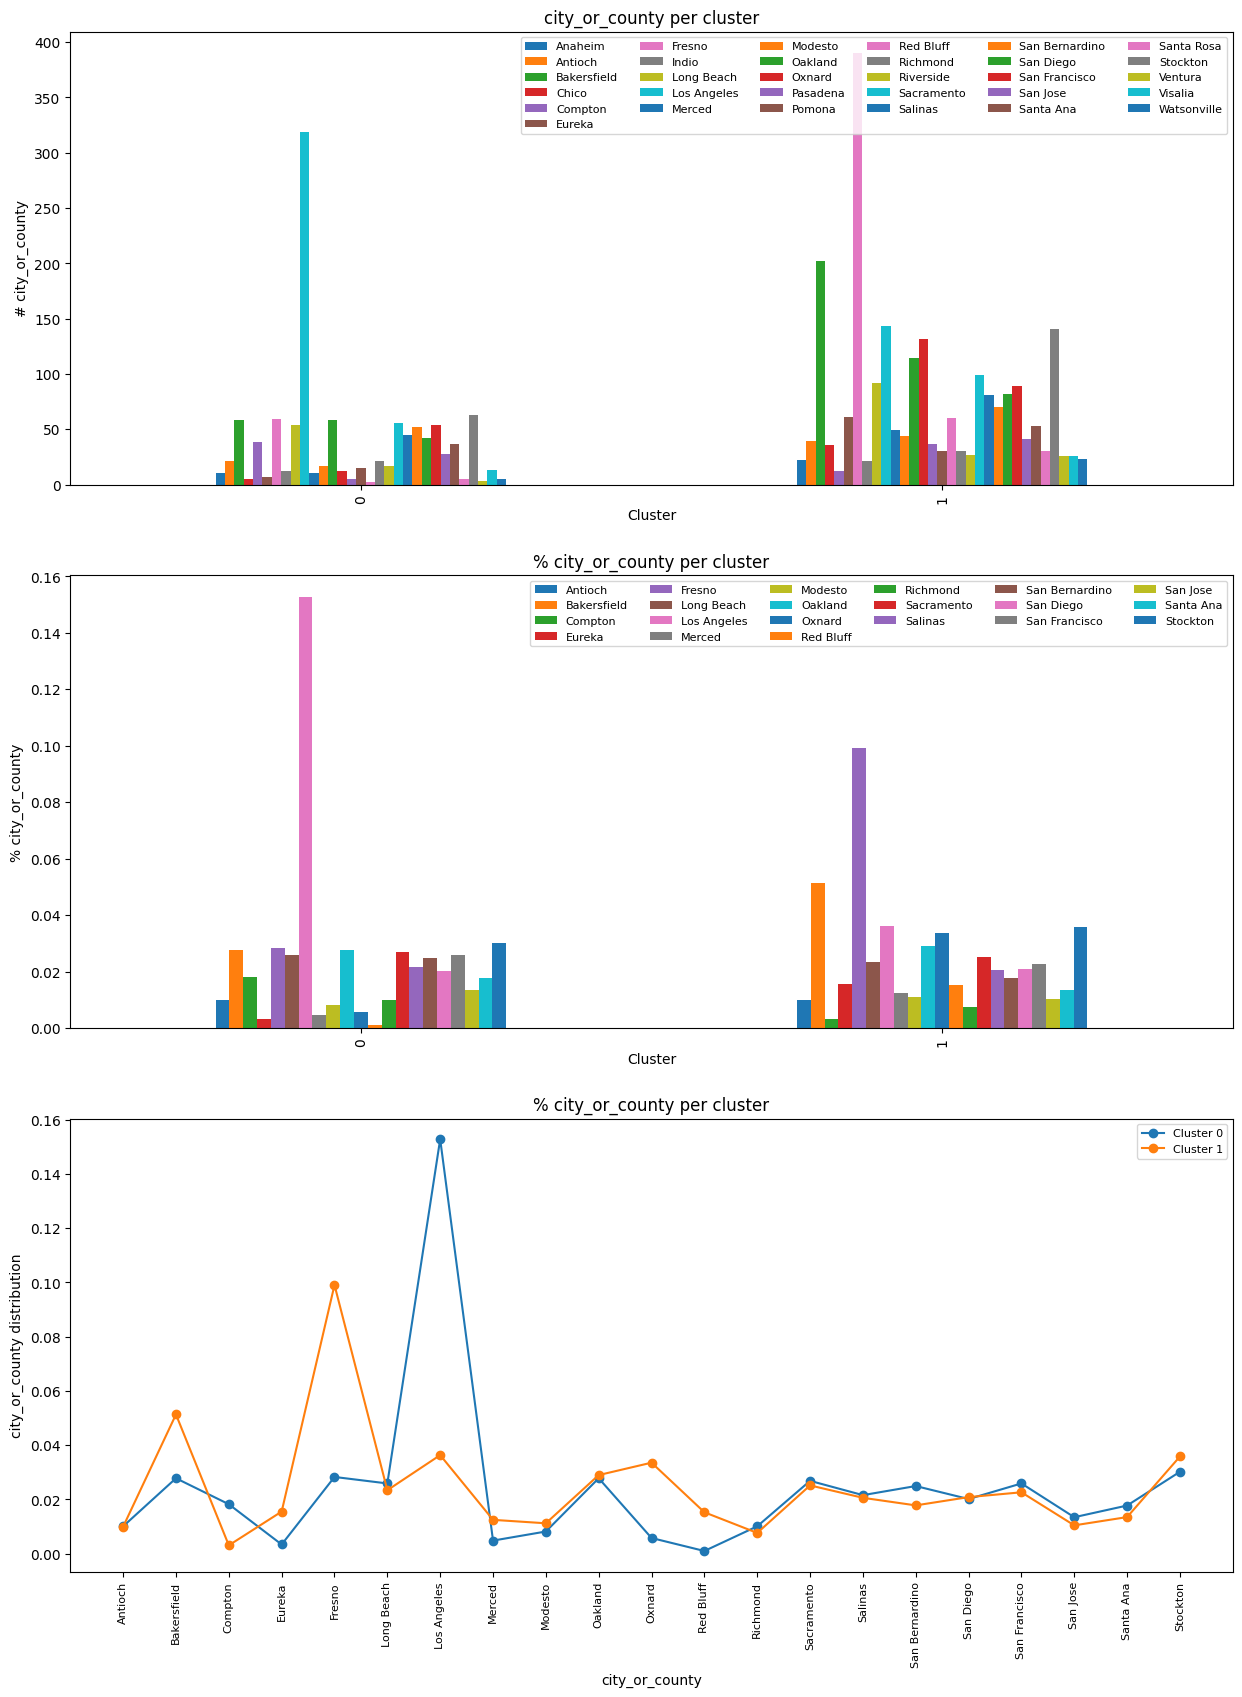

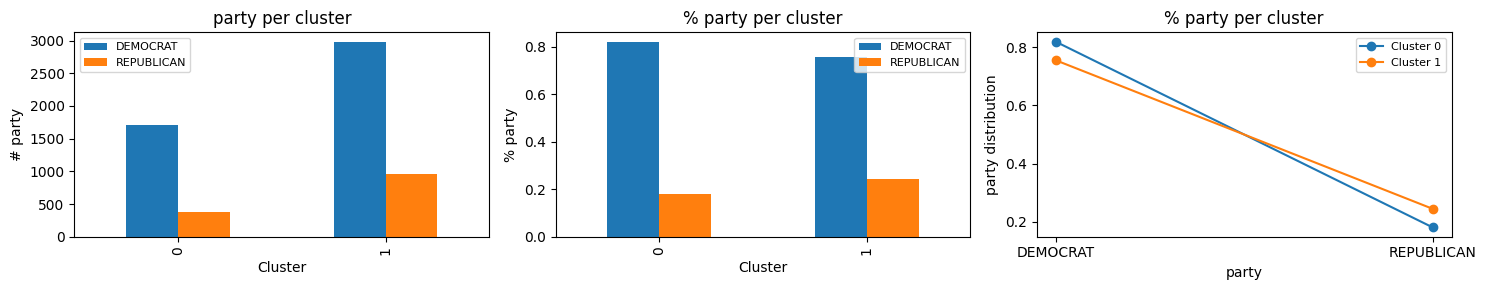

Augmented Reduced Model


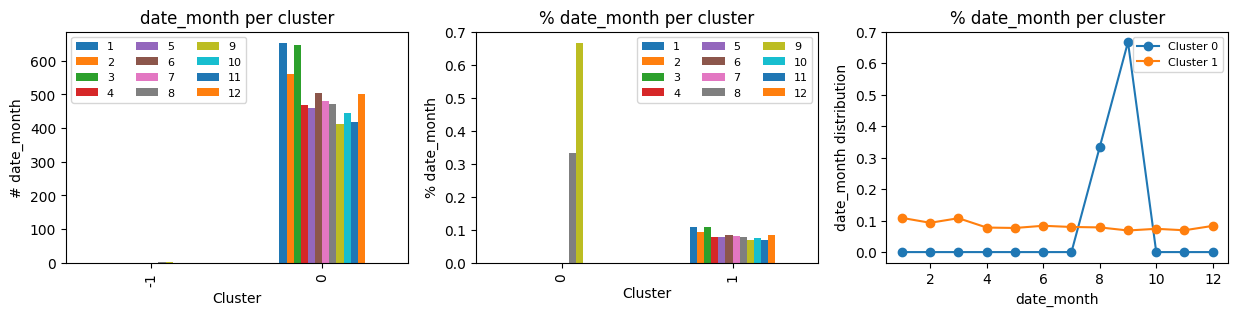

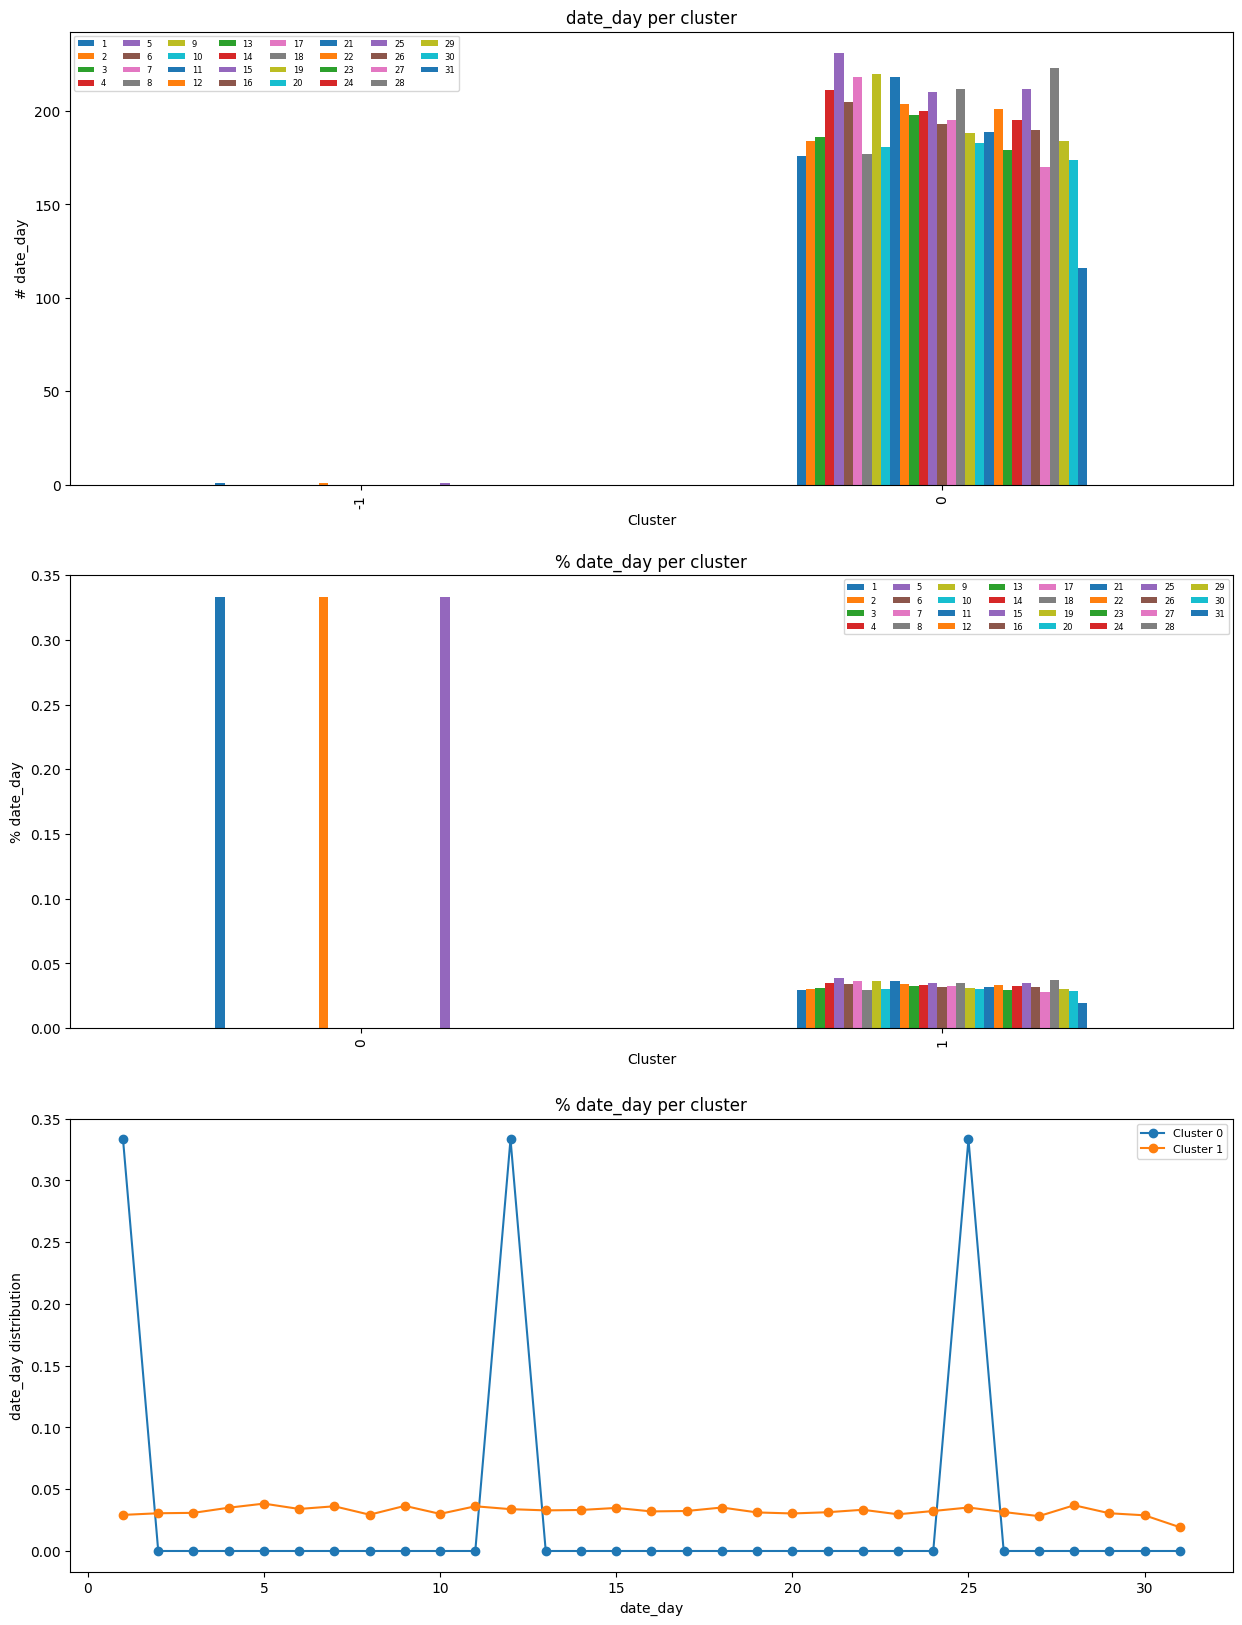

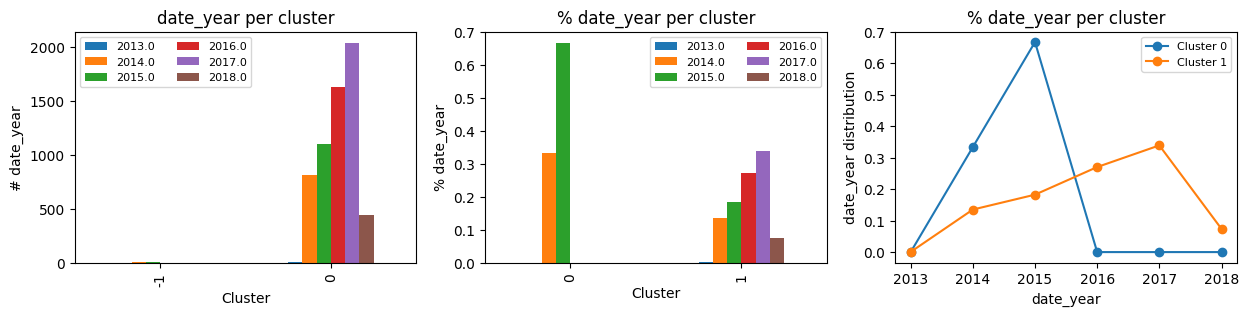

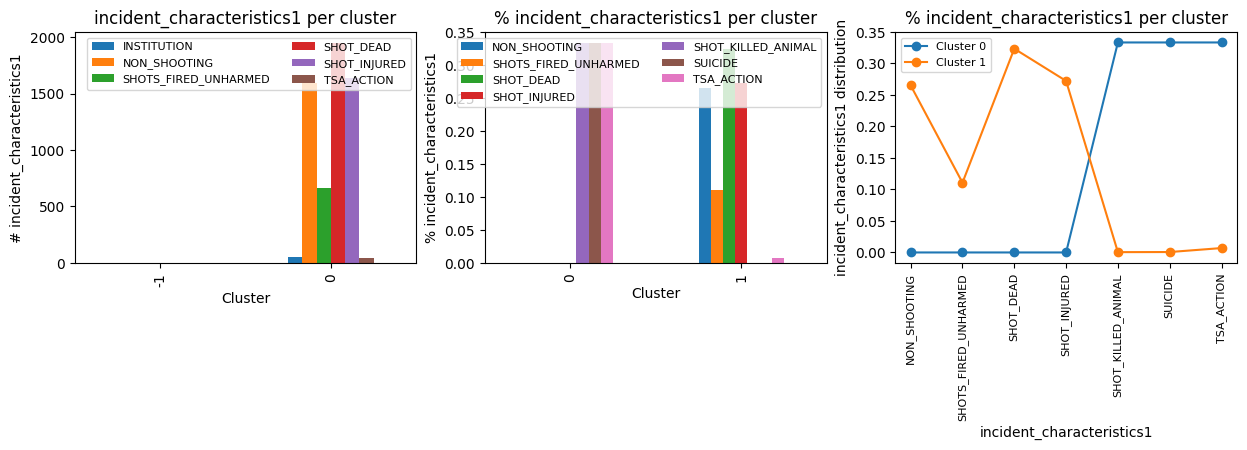

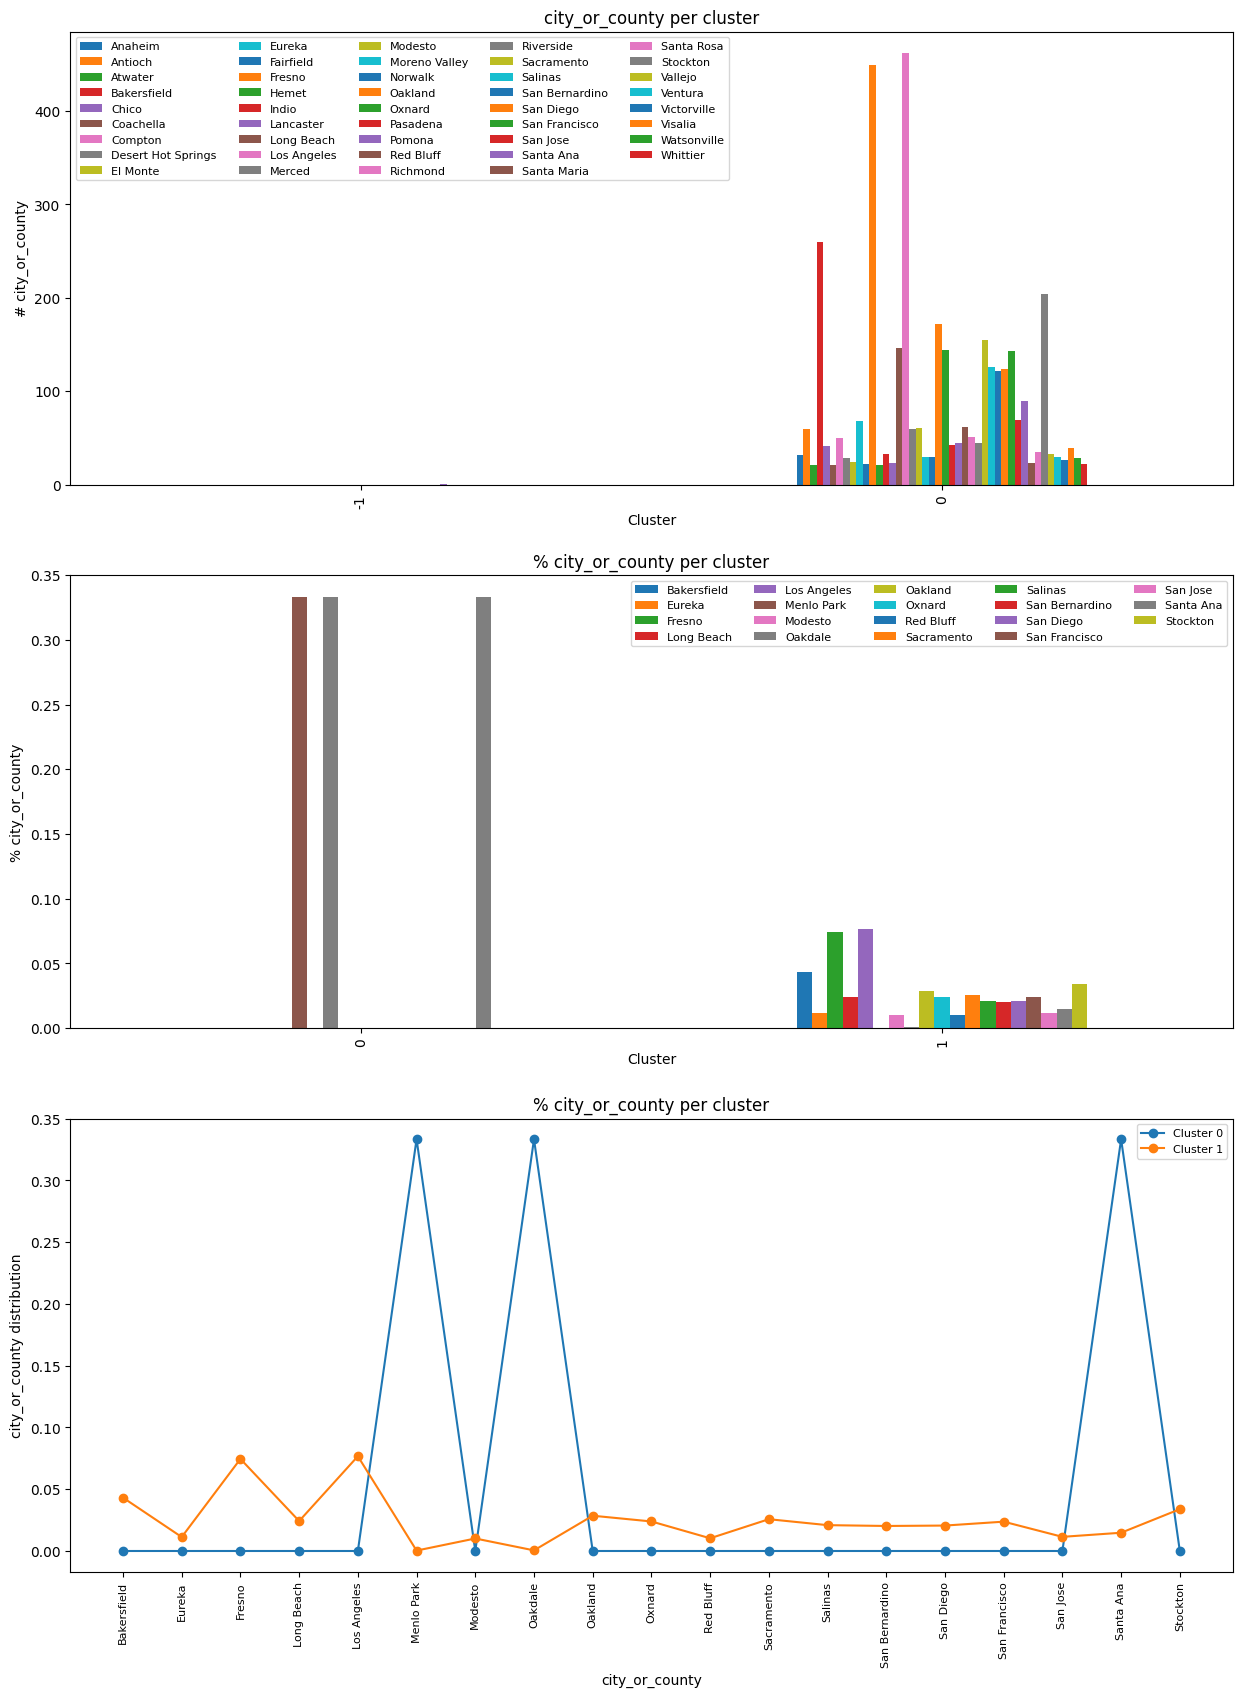

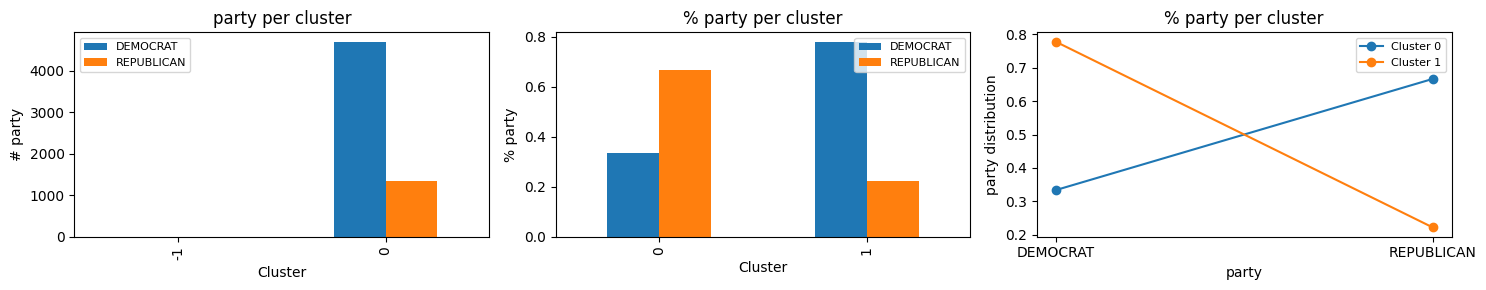

Indicators Reduced Model


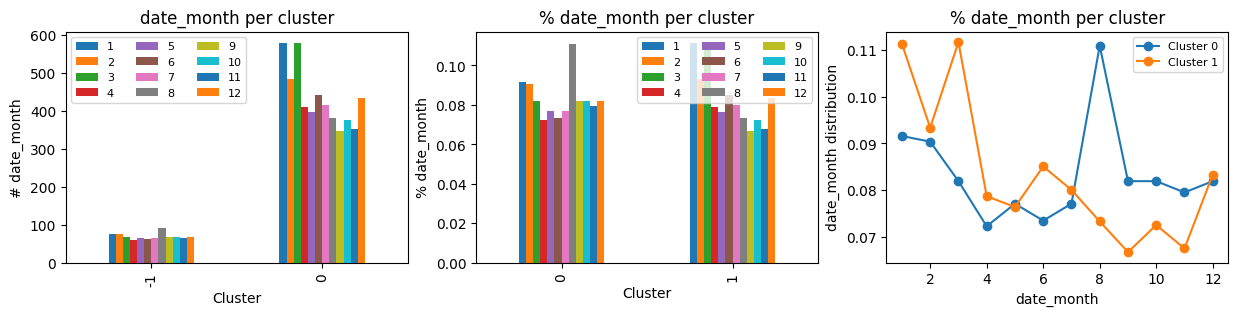

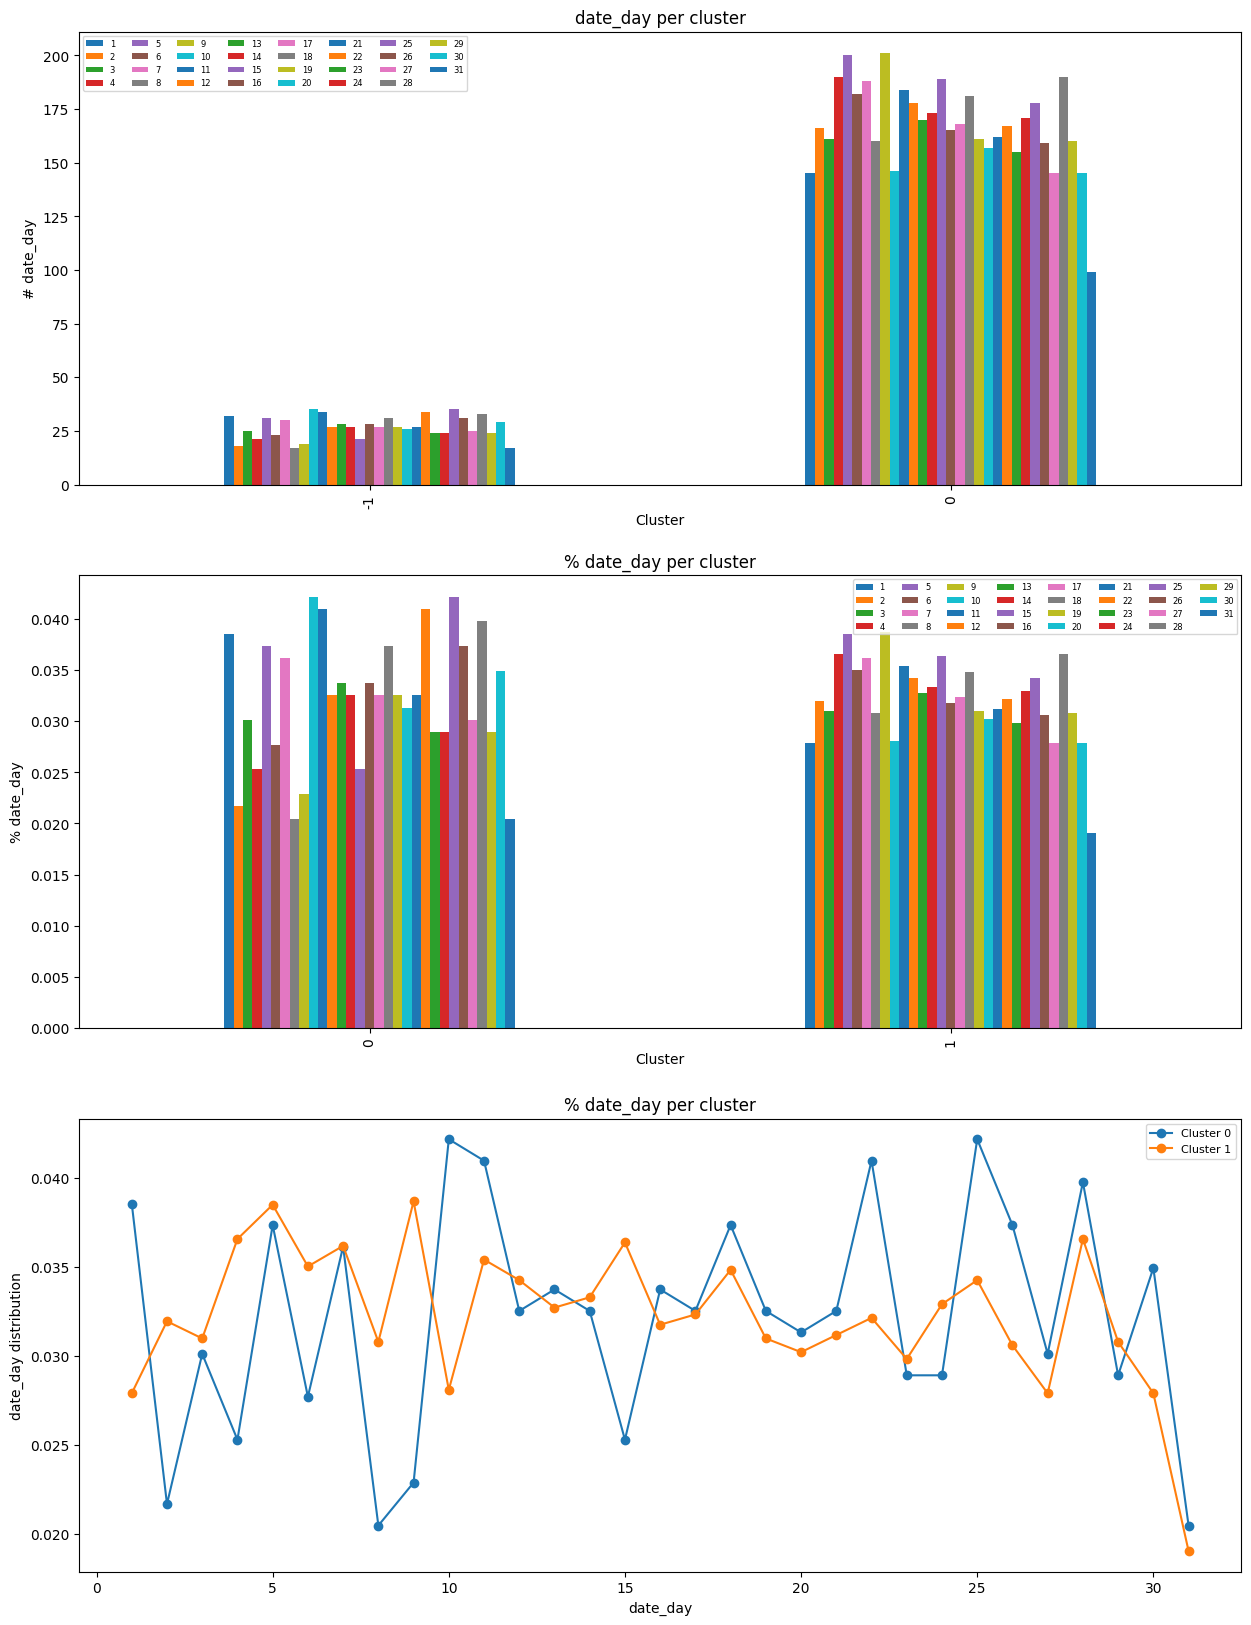

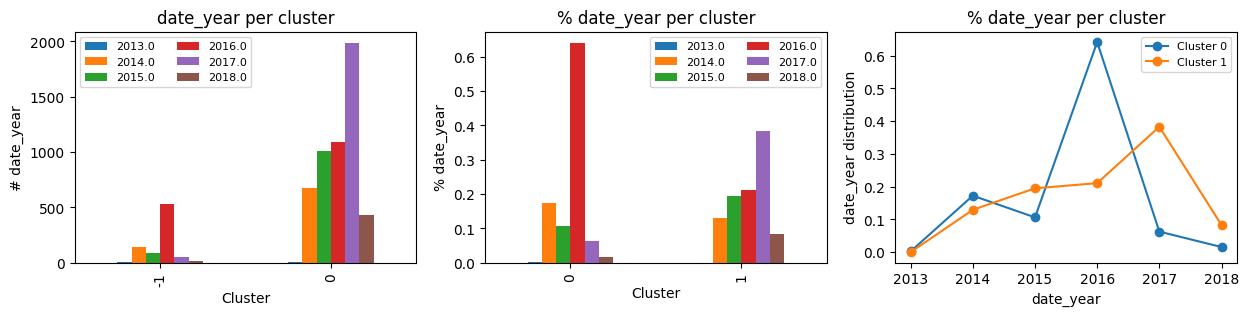

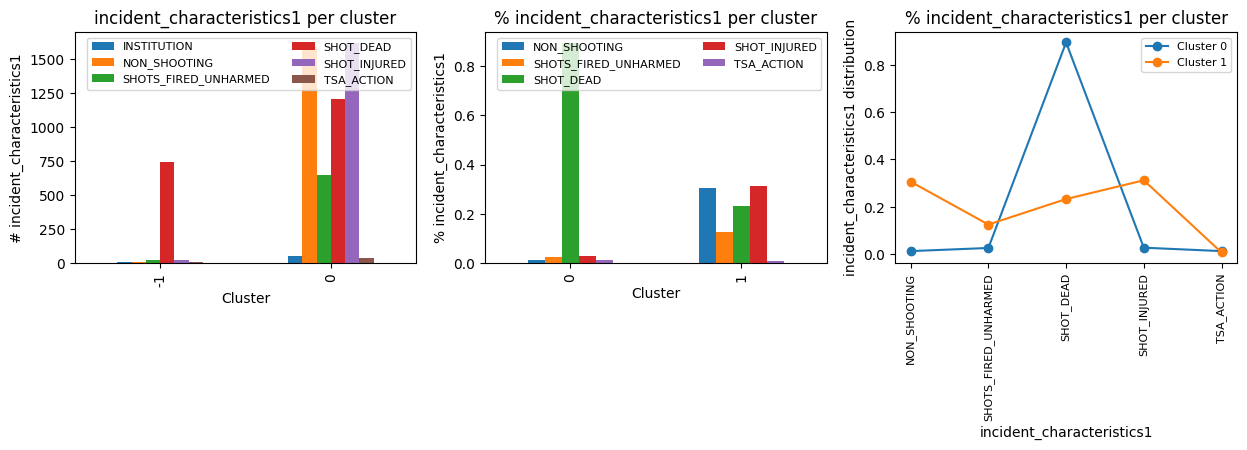

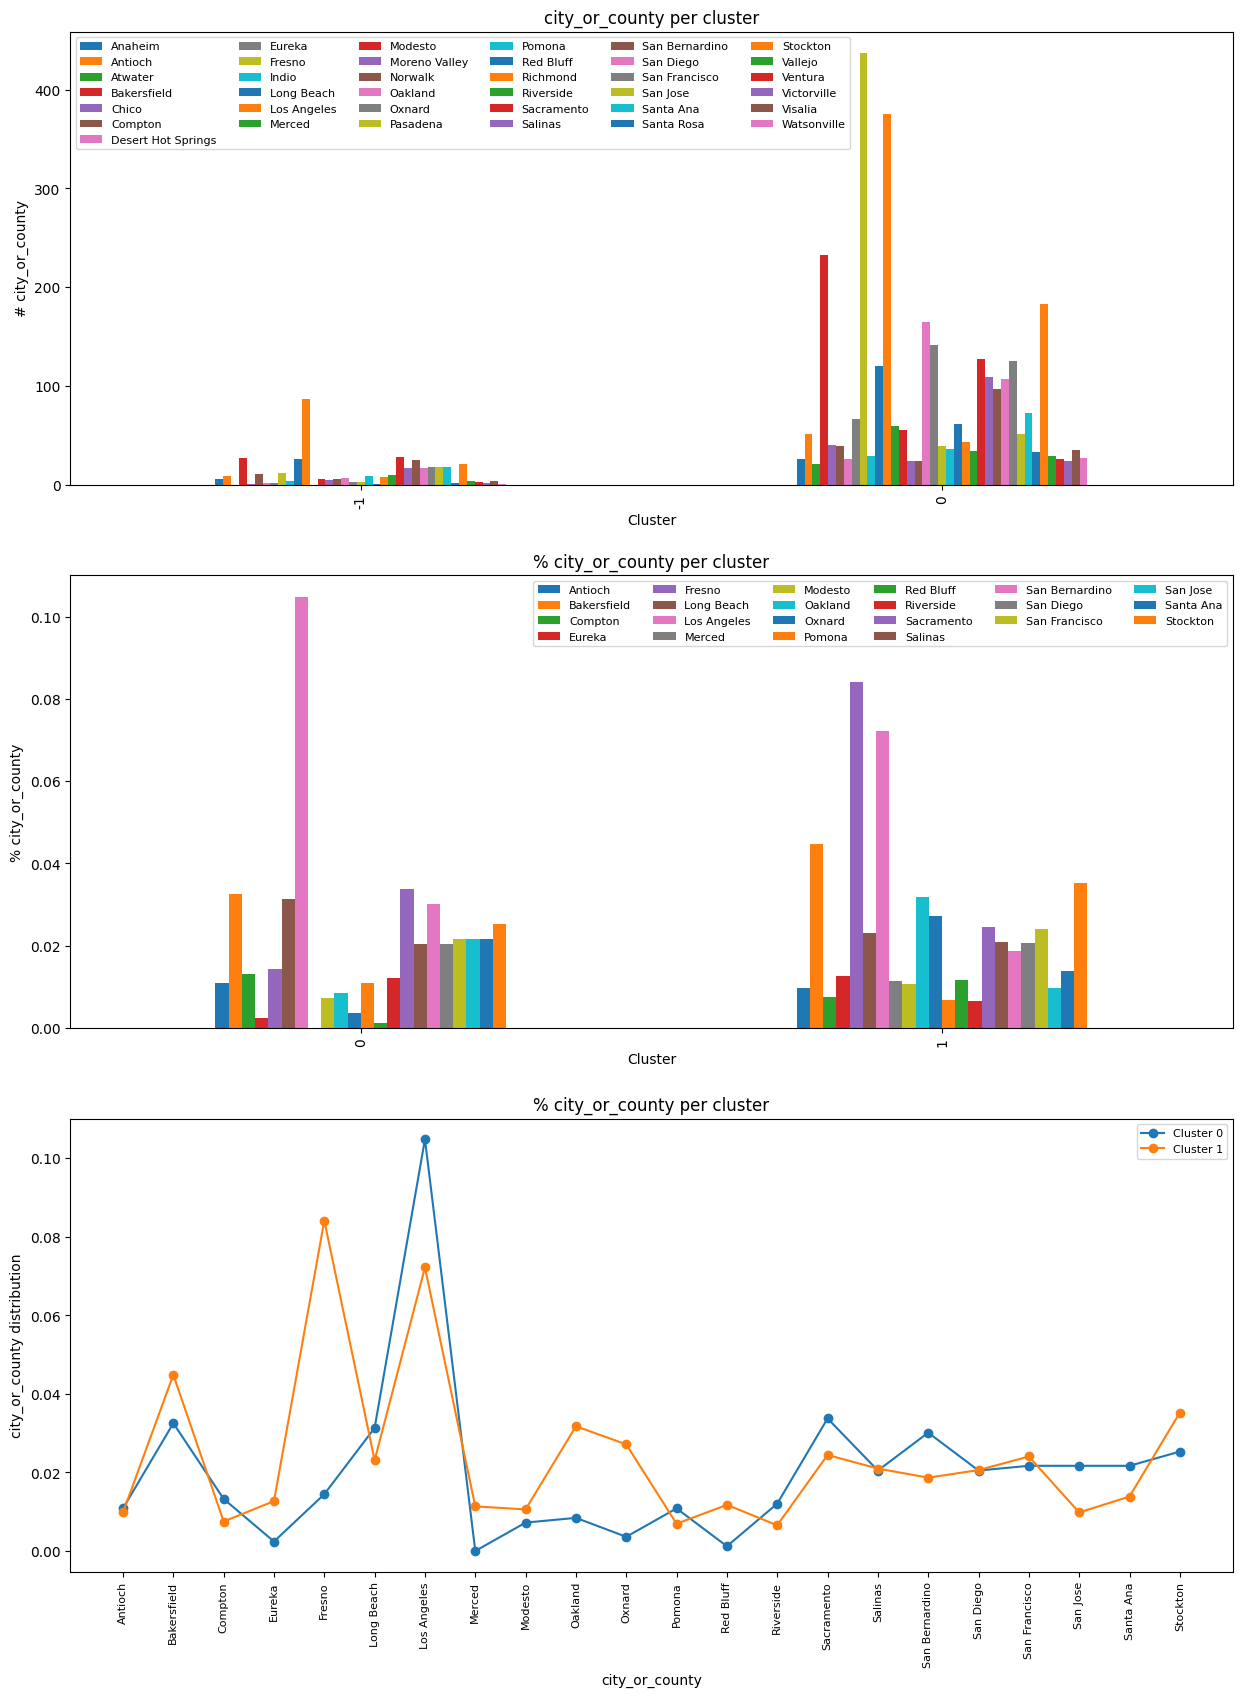

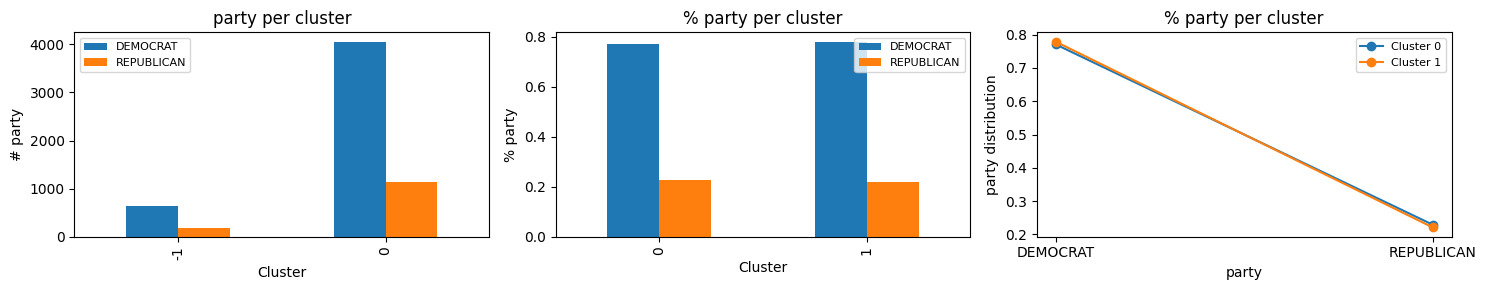

In [440]:
# categorical attributes distribution inside clusters

categoricals = ['date_month', 'date_day', 'date_year', 'incident_characteristics1', 'city_or_county', 'party']
df_c = df_init[categoricals]
n_models = len(all_best_models)

for model, model_name, means in zip(true_best_models, model_names[0:6], true_meanss):
    print(model_name)
    for cat in categoricals:

        xt_pct = pd.crosstab(model.labels_, df_c[cat])
        if cat == 'city_or_county':
            xt_pct = xt_pct.loc[:, (xt_pct > 0).any(axis=0)]

        a = xt_pct.values
        cols = xt_pct.columns
        ps = []
        for i in range(len(cols)):
            ps.append([])

        for row in a:
            dist = row / np.sum(row)
            for i in range(len(cols)):
                ps[i].append(dist[i])

        d = {}
        i = 0
        for c in cols:
            d[c] = ps[i]
            i += 1

        xt_pct_p = pd.DataFrame(d)
        if cat == 'city_or_county' or cat == 'incident_characteristics1':
            xt_pct_p = xt_pct_p.loc[:, (xt_pct_p > 0.01).any(axis=0)]
            xt_pct = xt_pct.loc[:, (xt_pct > 20).any(axis=0)]

        distrs = xt_pct_p.values
        cols = xt_pct_p.columns
        avg_distr = np.mean(distrs, axis=0)
        
    #----------------------------------------------
        if (cat == 'party' or cat == 'date_month' or cat == 'date_year' or cat == 'incident_characteristics1') and (len(means) <= 6):
            fig, axes = plt.subplots(1, 3, figsize=(15, 3))
        else:
            fig, axes = plt.subplots(3, 1, figsize=(15, 20))

        if len(cols) > 30:
            fs = 6
        else:
            fs = 8

        if cat == 'incident_characteristics1':
            ncol = ceil(len(cols) / 4)#6
        else:
            ncol = ceil(len(cols) / 4)

        xt_pct.plot(kind='bar', stacked=False, title=f'{cat} per cluster', ax=axes[0])
            
        axes[0].legend(fontsize=fs, loc='best', ncol=ncol)
        axes[0].set_xlabel('Cluster')
        axes[0].set_ylabel(f'# {cat}')

        xt_pct_p.plot(kind='bar', stacked=False, title=f'% {cat} per cluster', ax=axes[1])
        axes[1].legend(fontsize=fs, loc='best', ncol=ncol)
        axes[1].set_xlabel('Cluster')
        axes[1].set_ylabel(f'% {cat}')

        for i in range(len(means)):
            line, = axes[2].plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')
            if cat == 'incident_characteristics1' or cat == 'city_or_county':
                axes[2].set_xticks(range(len(cols)), cols, rotation=90, fontsize=8)

        ncol = ceil(len(means) / 4)
        axes[2].legend(fontsize=8, loc='best', ncol=ncol)
        axes[2].set_xlabel(cat)
        axes[2].set_ylabel(f'{cat} distribution')
        axes[2].set_title(f'% {cat} per cluster')
    
    plt.tight_layout()
    plt.show()